# Tanzania Water Well Classification

## Table of Contents

### 1. [Business Understanding](#Business-Understanding)
* 1.1 [Background](#Background)
* 1.2 [Business Goals](#Business-Goals)
* 1.3 [Business Success Criteria](#Business-Success-Criteria)
   
### 2. [Data Understanding](#Data-Understanding)
* 2.1 [Importing Packages and Reading in Data](#Importing-Packages-and-Reading-in-Data)
* 2.2 [Previewing the Data](#Previewing-the-Data)
* 2.3 [Numeric Feature Investigation](#Numeric-Feature-Investigation)
  * 2.3.1 [Summary Statistics](#Summary-Statistics)
  * 2.3.2 [Distribution Visualizations](#Distribution-Visualizations)
* 2.4 [Inspecting Null Values](#Inspecting-Null-Values) 
* 2.5 [Investigating Cardinality and Feature Contents](#Investigating-Cardinality-and-Feature-Contents)
* 2.6 [Inspecting Class Distribution](#Inspecting-Class-Distribution)
  * 2.6.1 [Mapping Well Status](#Mapping-Well-Status)
* 2.7 [Initial Data Observations](#Initial-Data-Observations)

### 3. [Data Preparation](#Data-Preparation)
* 3.1 [Dealing with Duplicates](#Dealing-with-Duplicates)
* 3.2 [`installer` Feature](#`installer`-Feature)
* 3.3 [Handling Null Values](#Handling-Null-Values)
* 3.4 [Target Reclassification](#Target-Reclassification)
  * 3.4.1 [Converting to Boolean Binary Target](#Converting-to-Boolean-Binary-Target)
* 3.5 [`management` vs. `management_group` vs. `scheme_management`](#`management`-vs.-`management_group`-vs.-`scheme_management`)
  * 3.5.1 [Feature Selection with `feature importances_`](#Feature-Selection-with-`feature-importances_`)
* 3.6 [`region` vs. `district_code`](#`region`-vs.-`district_code`)

### 4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
* 4.1 [Numeric Features: Density Plots](#Numeric-Features:-Density-Plots)
* 4.2 [Boolean Features: Countplots](#Boolean-Features:-Countplots)
* 4.3 [Categorical Features: Countplot Grid](#Categorical-Features:-Countplot-Grid)
* 4.4 [Mapping Wells Countrywide](#Mapping-Wells-Countrywide)
    * 4.4.1 [Map by Well Status](#Map-by-Well-Status)
    * 4.4.2 [Map by Well Status and Population](#Map-by-Well-Status-and-Population)
    * 4.4.3 [Density Maps: Well Status and Population](#Density-Maps:-Well-Status-and-Population)

### 5. [Modeling](#Modeling)
* 5.1 [Train-Test-Split](#Train-Test-Split)
  * 5.1.1 [Evaluation Metrics Function](#Evaluation-Metrics-Function)
* 5.2 [Baseline Logistic Regression Model](#Baseline-Logistic-Regression-Model)
  * 5.2.1 [Preprocessing Categorial Features with `OneHotEncoder()`](#Preprocessing-Categorial-Features-with-`OneHotEncoder()`)
  * 5.2.2 [Preprocessing Numeric Features with `MinMaxScaler()`](#Preprocessing-Numeric-Features-with-`MinMaxScaler()`)
  * 5.2.3 [Training and Fitting Baseline Model](#Training-and-Fitting-Baseline-Model)
  * 5.2.4 [Evaluating Baseline Model](#Evaluating-Baseline-Model)
* 5.3 [Training Additional Models](#Training-Additional-Models)
  * 5.3.2 [Creating Pipelines for Additional Models](#Creating-Pipelines-for-Additional-Models)
  * 5.3.3 [Training and Evaluating New Models](#Training-and-Evaluating-New-Models)
* 5.4 [Decision Tree Feature Selection and Hyperparameter Tuning](#Decision-Tree-Feature-Selection-and-Hyperparameter-Tuning)
  * 5.4.1 [Feature Selection with `feature_importances_`](#Feature-Selection-with-`feature_importances_`)
  * 5.4.2 [Feature Selection with RFE](#Feature-Selection-with-RFE)
  * 5.4.3 [Hyperparameter Tuning](#hyperparameter-tuning)
* 5.5 [Random Forest Feature Selection and Hyperparameter Tuning](#Random-Forest-Feature-Selection-and-Hyperparameter-Tuning)
  * 5.5.1 [Feature Selection with RFE](#Feature-Selection-with-RFE)
  * 5.5.2 [Hyperparameter Tuning](#Hyperparameter-Tuning)

### 6. [Evaluation](#Final-Model-Evaluation)
* 6.1 [Final Decision Tree Fit and Evaluation](#Final-Decision-Tree-Fit-and-Evaluation)
* 6.2 [Final Random Forest Fit and Evaluation](#Final-Random-Forest-Fit-and-Evaluation)
* 6.3 [Initial Random Forest Evaluation on Test Data](#Initial-Random-Forest-Evaluation-on-Test-Data)
* 6.4 [Baseline Logistic Regression Model Evaluation on Test Data](#Baseline-Logistic-Regession-Model-Evaluation-on-Test-Data)
* 6.5 [Model Evaluations with Table](#Model-Evaluations-with-Table)

### 7. [Conclusions](#Conclusions)
* 7.1 [Limitations](#Limitations)
* 7.2 [Recommendations](#Recommendations)
* 7.3 [Next Steps](#Next-Steps)

### 8. [Resources](#Resources)

## 1. <a name ="Business-Understanding"></a> Business Understanding

### 1.1 <a name ="Background"></a> Background 

The country of Tanzania is struggling to provide safe, clean water to its more than 67 million citizens. A non-governmental organization (NGO) is assisting the Tanzanian government in addressing this critical issue by repairing damaged water wells. With over 70k water wells scattered across an area larger than twice the size of California, testing every single well is both costly and time-consuming.

Water from these wells is not only vital for drinking but also essential for cooking, sanitation, and hygiene practices. Ensuring access to clean water significantly impacts the health and livelihoods of the community. Therefore, the NGO requires an efficient method to identify which water wells need repair, streamlining their efforts to provide safe, clean water for all Tanzanians.

### 1.2 <a name ="Business-Goals"></a> Business Goals

The primary focus of this machine learning project is to assist the NGO in identifying all water wells requiring repair, enabling timely interventions to ensure safe, clean water for Tanzanians. Specifically, the project aims to accurately identify every well in need of repair while minimizing false ***negatives***—cases where a well is incorrectly classified as functioning when, in fact, it requires repair.

Although some functional wells may be incorrectly classified as needing repair, the prevention of potential health hazards is of utmost importance. Therefore, the model prioritizes identifying wells that need repair, erring on the side of caution to ensure the safety of citizens who rely on these essential water sources.

### 1.3 <a name ="Business-Success-Criteria"></a> Business Success Criteria

The success of this project will be measured primarily by the model’s ability to classify wells in need of repair. The key metric associated with this ability is called recall, which addresses the question: 

> _“Out of all the wells that actually need repair, what percentage did our model correctly identify as needing repair?”_ 

Recall is calculated by dividing the number of true positives (the number of wells that genuinely require repair) by the combined total of true positives and false negatives (the wells that require repair but were incorrectly labeled as functional). 

$$
\text{Recall} = \frac {\text{True  Positives}}{\text{True  Positives + False  Negatives}}
$$

While other metrics, such as accuracy and precision, are often used to evaluate classification models, recall is most suitable here because it addresses the primary goal of identifying all wells needing repair. For instance, high precision would mean that when the model predicts a repair need, it is usually correct. However, this would not be as beneficial here. If the model only predicts repair needs for a few wells, it risks missing many others, potentially leaving large gaps in coverage. Similarly, focusing on accuracy could yield a model that classifies most wells as needing repair if there’s a class imbalance, without improving the efficiency or impact of repairs.

By focusing on recall, this project will help the NGO allocate its resources more effectively, reducing costs and time associated with well testing, and ultimately supporting improved public health and quality of life in Tanzania.

## 2. <a name ="Data-Understanding"></a> Data Understanding

This data was collected by Taarifa and the Tanzanian Ministry of Water. The dataset includes 41 features and 59400 entries. 

Each entry in the dataset represents a water well in Tanzania, where `id` is its unique identifier. Additional information is included about each well such as the `latitude` and `longitude`, along with its water source --`source_type`-- and its total static head --`amount_tsh`-- (in other words the amount of water available to waterpoint). 

The target in this classification problem is stored in the column labeled `status_group`. Prior to any cleaning and preprocessing, this column includes three classes: functional, functional needs repair, and non-functional.

More information about the data can be found [here]( https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/data/).

### 2.1 <a name ="Importing-Packages-and-Reading-in-Data"></a> Importing Packages and Reading in Data

In [1]:
# importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# for GIS/mapping
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.patches as mpatches
import matplotlib.patches as patches
from matplotlib.lines import Line2D

# for splitting into training, test, and validation sets
from sklearn.model_selection import train_test_split, cross_val_score

# feature selection
from sklearn.feature_selection import RFE

# classification models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

# preprocessing 
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

# for saving models
import pickle

# metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report

In [2]:
# reading csv files for training data and labels

target = pd.read_csv('./data/training_set_labels.csv')
features = pd.read_csv('./data/training_set_values.csv')

### 2.2 <a name ="Previewing-the-Data"></a> Previewing the Data

In [3]:
features.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [5]:
target.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [6]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [7]:
data = features.merge(target, how = 'inner', on = 'id')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [8]:
data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


### 2.3 <a name ="Numeric-Feature-Investigation"></a> Numeric Feature Investigation

#### 2.3.1 <a name ="Summary-Statistics"></a> Summary Statistics

In [9]:
data.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


This output shows the summary statistics for the numeric columns. From this output, we can see that gps_height and population appear to be right skewed due to the fact that the mean is significantly larger than the median. This indicates the probable presence of outliers. 

#### 2.3.2  <a name ="Distribution-Visualizations"></a> Distribution Visualizations

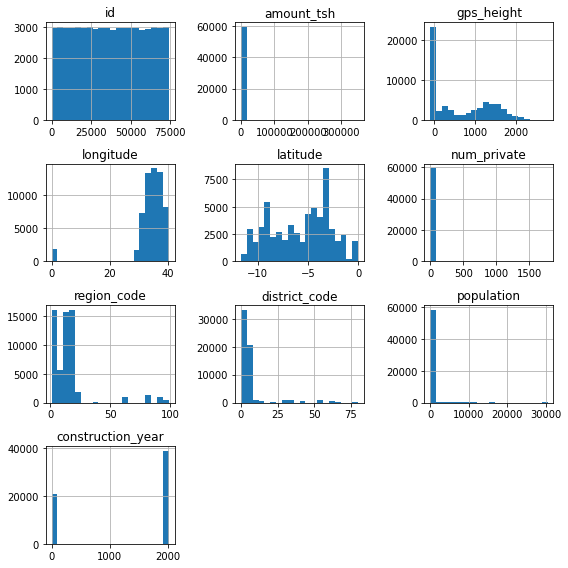

In [10]:
data.hist(bins = 20, figsize = (8,8))

plt.tight_layout()
plt.savefig('./visualizations/histograms.png', dpi=300)
plt.show();

This output visualizes the distributions for the different numeric features prior to any data cleaning. This provides some insight into potential features to investigate more closely, such as `construction_year` as there appears to be almost 20,0000 wells with the year of 0 or nearly zero. 

### 2.4  <a name ="Inspecting-Null-Values"></a> Inspecting Null Values

In [11]:
# getting the percentage of null values in each feature

round((data.isna().sum()*100)/len(data), 2)

id                        0.00
amount_tsh                0.00
date_recorded             0.00
funder                    6.12
gps_height                0.00
installer                 6.15
longitude                 0.00
latitude                  0.00
wpt_name                  0.00
num_private               0.00
basin                     0.00
subvillage                0.62
region                    0.00
region_code               0.00
district_code             0.00
lga                       0.00
ward                      0.00
population                0.00
public_meeting            5.61
recorded_by               0.00
scheme_management         6.53
scheme_name              48.50
permit                    5.14
construction_year         0.00
extraction_type           0.00
extraction_type_group     0.00
extraction_type_class     0.00
management                0.00
management_group          0.00
payment                   0.00
payment_type              0.00
water_quality             0.00
quality_

This outputs the percentage of data within each feature that is null values. From this, we see that funder, installer, subvillage, public_meeting, scheme_management, permit all have only a small percentage of missing values. scheme_name at almost 50% is the only feature with a percentage of null values above 10%. This feature will be a focus during the data preprocessing phase.  

### 2.5  <a name ="Investigating-Cardinality-and-Feature-Contents"></a> Investigating Cardinality and Feature Contents

In [12]:
data.nunique()

id                       59400
amount_tsh                  98
date_recorded              356
funder                    1896
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
wpt_name                 37399
num_private                 65
basin                        9
subvillage               19287
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
recorded_by                  1
scheme_management           11
scheme_name               2695
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_

In [13]:
# defining a function to assist with cardinality assessment of each feature
# this function prints the value counts for each feature in the given dataset

def multiple_value_counts(dataframe,list_of_columns):
    for col in list_of_columns:
        print("----" + col + "----")
        print()
        print(dataframe[col].value_counts())
        print()

In [14]:
multiple_value_counts(data, data.columns)

----id----

id
69572    1
27851    1
6924     1
61097    1
48517    1
        ..
59036    1
56446    1
3855     1
52786    1
26348    1
Name: count, Length: 59400, dtype: int64

----amount_tsh----

amount_tsh
0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
6300.0          1
120000.0        1
138000.0        1
350000.0        1
59.0            1
Name: count, Length: 98, dtype: int64

----date_recorded----

date_recorded
2011-03-15    572
2011-03-17    558
2013-02-03    546
2011-03-14    520
2011-03-16    513
             ... 
2011-09-11      1
2011-08-31      1
2011-09-21      1
2011-08-30      1
2013-12-01      1
Name: count, Length: 356, dtype: int64

----funder----

funder
Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Muwasa                       1
Msigw                        1
Rc Mofu 

The above output gives the value counts and number of unique entries for each feature in the training data. This helps understand the cardinality of each feature. Features with high cardinality, such as wpt_name (37400 unique entries) and subvillage (19287 unique entries), may not be helpful in this classification. Thus, these features will be an area of focus during the data preparation phase. 

In [15]:
# displays values within the funder feature

data['funder'].str.lower().value_counts()

funder
government of tanzania    9084
danida                    3114
hesawa                    2202
rwssp                     1374
world bank                1349
                          ... 
muwasa                       1
msigw                        1
rc mofu                      1
overland high school         1
samlo                        1
Name: count, Length: 1896, dtype: int64

In [16]:
#displays categories within installer feature

data['installer'].str.lower().value_counts()

installer
dwe             17405
government       1891
hesawa           1395
rwe              1206
commu            1065
                ...  
amadi               1
jafary mbaga        1
sa                  1
luleka              1
selepta             1
Name: count, Length: 1935, dtype: int64

In [17]:
data[['water_quality', 'quality_group']].value_counts()

water_quality       quality_group
soft                good             50818
salty               salty             4856
unknown             unknown           1876
milky               milky              804
coloured            colored            490
salty abandoned     salty              339
fluoride            fluoride           200
fluoride abandoned  fluoride            17
Name: count, dtype: int64

In [18]:
#calculates the percentage of installers known as DWE

round(data['installer'].value_counts()['DWE']/ 
      data['installer'].count(), 2) * 100

31.0

In [19]:
# calculates the percentage of construction years that are 0
round(data['construction_year'].value_counts()[0]/ 
      data['construction_year'].count(), 2) * 100

35.0

In [20]:
# examining the entries of wells with longitude = 0
data[data['longitude'] == 0]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
21,6091,0.0,2013-02-10,Dwsp,0,DWE,0.0,-2.000000e-08,Muungano,0,...,unknown,unknown,unknown,unknown,shallow well,shallow well,groundwater,hand pump,hand pump,functional
53,32376,0.0,2011-08-01,Government Of Tanzania,0,Government,0.0,-2.000000e-08,Polisi,0,...,unknown,unknown,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
168,72678,0.0,2013-01-30,Wvt,0,WVT,0.0,-2.000000e-08,Wvt Tanzania,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
177,56725,0.0,2013-01-17,Netherlands,0,DWE,0.0,-2.000000e-08,Kikundi Cha Wakina Mama,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
253,13042,0.0,2012-10-29,Hesawa,0,DWE,0.0,-2.000000e-08,Kwakisusi,0,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59189,62177,0.0,2011-07-18,Dwsp,0,DWE,0.0,-2.000000e-08,Wazazo,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
59208,3631,0.0,2013-01-22,Dwsp,0,DWE,0.0,-2.000000e-08,Mtakuja,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
59295,60843,0.0,2011-07-19,Rwssp,0,DWE,0.0,-2.000000e-08,Maendeleo,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
59324,748,0.0,2013-01-22,World Vision,0,World Vision,0.0,-2.000000e-08,Mwazwilo,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional


In [21]:
# examining the latitudes of wells with longitude = 0
data[data['longitude'] == 0].latitude.value_counts()

latitude
-2.000000e-08    1812
Name: count, dtype: int64

In [22]:
# examining the amount_tsh of wells with longitude = 0
data[data['longitude'] == 0].amount_tsh.value_counts()

amount_tsh
0.0    1812
Name: count, dtype: int64

### 2.6  <a name ="Inspecting-Class-Distribution"></a> Inspecting Class Distribution

Below we see that the target has three classes for the type of well: 'functional', 'nonfunction', and 'functional needs repair'. In additional to the ambiguity of the class label 'functional needs repair', there is slight class imbalance with the most frequent class 'functional' at 54% and then the next most frequent class, 'non functional' at 38%. Further in this project, I will attempt to simplify this classification problem by converting the labels so that there's only two classes. This will help to make the labels clearer for interpretability along with helping alleviate some of the class imbalance. 

In [23]:
# Gives the class distribution for the target
data.status_group.value_counts()

status_group
functional                 32259
non functional             22824
functional needs repair     4317
Name: count, dtype: int64

The output above shows that the target has three classes. For practicality, I will turn this into a binary classification problem

In [24]:
# Gives the class distribution for the target as a percentage

round(data.status_group.value_counts(normalize = True), 2) * 100

status_group
functional                 54.0
non functional             38.0
functional needs repair     7.0
Name: proportion, dtype: float64

The above output displays the three target classes as percentages. From this output, we see that the target classes have some imbalance with 'functional' wells at 54% and then 'non fuctional' well at 38%. Turning this into a binary classification will also help with the class imbalance.

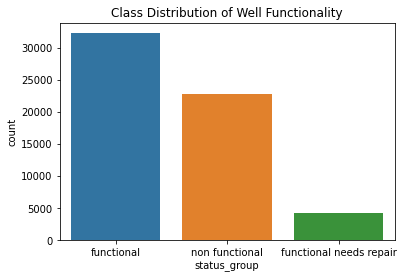

In [25]:
# Barplot of the class distribution
sns.barplot(x = data.status_group.value_counts().index,
            y = data.status_group.value_counts(), 
).set_title('Class Distribution of Well Functionality')

plt.savefig("./visualizations/ternary_class_distribution_barplot.png", dpi=300, bbox_inches='tight') 

plt.show();

This bar graph visualizes the class distribution of the target variable `status_group`. It allows us to bette see the slight class imbalance. 

#### 2.6.1  <a name ="Mapping-Well-Status"></a>Mapping Well Status 

In order to get a better sense of the wells and their functionality, I create a map to visualize the locations of the wells and try to see if any initial patterns emerge. From the map, we see that there are some outliers which will need to be taken care of during data preparation.

In [26]:
# creates a dataframe from the training_data which includes the list of points
tanzania_map = gpd.read_file('./data/regions/Regions.shp')

# Specifies the coordinate reference system
crs = "EPSG:4326"

# Creates list of point objects consisting of latitudes and longitudes
geometry = [Point(xy) for xy in zip(data['longitude'], data['latitude'])]

# Creates a GeoDataFrame from the data, including the list of points
geo_df = gpd.GeoDataFrame(data,
                          crs=crs,
                          geometry=geometry)

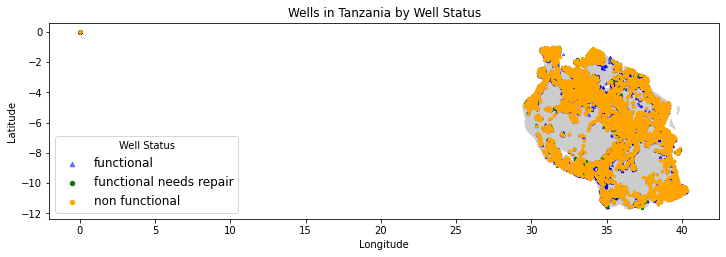

In [27]:
# plots map of Tanzania with points of wells overlaid

fig, ax = plt.subplots(figsize = (12, 12))
tanzania_map.plot(ax=ax, alpha=0.4, color='grey')

geo_df[geo_df['status_group'] == 'functional'].plot(ax=ax, 
                                      markersize=5, 
                                      color='blue', 
                                      marker='^', 
                                      label='functional',
                                      alpha = 0.5
                                                          )
geo_df[geo_df['status_group'] == 'functional needs repair'].plot(ax=ax, 
                                       markersize=5, 
                                       color='green', 
                                       marker='o', 
                                       label='functional needs repair'    
                                                     )

geo_df[geo_df['status_group'] == 'non functional'].plot(ax=ax, 
                                       markersize=5, 
                                       color='orange', 
                                       marker='o', 
                                       label='non functional'    
                                                     )

plt.title("Wells in Tanzania by Well Status")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Well Status", fontsize=12,  markerscale=2)

plt.savefig("./visualizations/tanzania_wells_map.png", dpi=300)

plt.show();

The map shows the location of wells in Tanzania categorized by the status group - "functional" (blue), "functional needs repair" (green) or "non functional" (orange). From this map, it brings our attention to the points located in the northwest corner of the map. These points will be an area to address during the data preparation portion. It also shows us that the distribution of functional, functional needs repair, and non functional wells is evenly dispursed amongst the country with no real patterns emerging in any specific area for a well group. 

### 2.7  <a name ="Initial-Data-Observations"></a> Initial Data Observations

After an initial inspection of the dataset, several key areas have been identified for attention during the data cleaning stage:


**Duplicate or Redundant Features**

Many features seem to provide overlapping or similar information. Examples include:
- `scheme_name` vs. `scheme_management`
- `extraction_type`, `extraction_type_group`, and `extraction_type_class`
- `management` vs. `management_group`
- `payment` vs. `payment_type`
- `water_quality` vs. `quality_group`
- `quantity` vs. `quantity_group`
- `source`, `source_type`, and `source_class`
- `waterpoint_type` vs. `waterpoint_type_group`


**Geographic Features**
Several features provide information about geographic location:
- `subvillage`
- `region`
- `region_code`
- `district_code`
- `lga`
- `ward`


**Features to Consider Dropping**

Some features may not be useful due to a high proportion of missing values, redundancy, or lack of meaningful information:
- `scheme_name`: 47% of values are null, likely limiting its utility for analysis or machine learning.

- `num_private`: The data description does not clarify this feature’s purpose, making it difficult to interpret.

`wtp_name`: Appears redundant since each well already has a unique ID.


**Features for Further Investigation**

The following features require deeper analysis to determine their value:
- `amount_tsh`: Over 40,000 entries are 0. Do these represent missing data or wells needing repair?
- `date_recorded`: Indicates the date the data was recorded. This might not be directly useful for machine learning.
- `public_meeting`: Its meaning and importance are unclear.
- `construction_year`: Nearly 35% of entries are 0. Should these be treated as null values?
- Coordinates (longitude and latitude): 1,812 entries have identical coordinates (longitude = 0 and latitude = -2.0e8), which may correspond to wells mapped outside the country.

- `installer`: This feature might significantly affect well functionality but has high cardinality (over 2,000 unique values). Cleaning this feature may enhance its utility.

## 3. <a name ="Data-Preparation"></a> Data Preparation

Based on my observations in the Data Understanding phase, I completed the following steps during the data preparation phase to clean and prepare the dataset for modeling:


1. **Dealing with Duplicates**: 
- Irrelevant features or those containing duplicate information were dropped. In cases where two features contained the same information, the feature with lower cardinality was retained, as lower cardinality typically leads to smoother machine learning processes.


2. **Processing the `installer` Feature**: 
- The high cardinality of the `installer` feature (2,145 unique values) was addressed by grouping similar entries and narrowing the focus to the top 25 installers based on frequency. All other installers were classified as “Other,” reducing the cardinality from 2,145 to 25.


3. **Handling Null Values**: 
- At this stage, only three features contained null values, and none had more than 7% of their entries missing. Since dropping these rows would not result in a significant loss of data, I decided to remove them.


4. **Reclassifying the Target Variable**: 
- The original target variable was first reclassified from three classes into two classes, and then converted into a binary Boolean target. This was done to simplify modeling and ensure consistent interpretation of well functionality, aligning with the project’s objectives.


5. **Feature Engineering and Selection**: 
- For the `management` vs. `management_group` vs. `scheme_management` and `region` vs. `district_code` features, I trained simple decision trees using each set of features individually. By examining the feature_importances_ attribute, I identified the most significant variable from each group. The top feature from each pair was then selected and retained for further modeling.

By the end of the data cleaning process, the dataframe was reduced to 19 columns, down from 40, and 47,000 rows, down from nearly 60,000, with all null values removed. Despite the reduction of over 10,000 entries, 47,000 rows still provides plenty of data for training the models, even after performing the train-test split.

### 3.1 <a name ="Dealing-with-Duplicates"></a> Dealing with Duplicates

In [28]:
data[['installer', 'funder']].value_counts()

installer     funder                
DWE           Government Of Tanzania    4254
Government    Government Of Tanzania    1607
DWE           Hesawa                    1296
DANIDA        Danida                    1046
DWE           Rwssp                      914
                                        ... 
KA            If                           1
KADP          Kadip                        1
KAEM          Kaemp                        1
KAEMP         Government Of Tanzania       1
world vision  World Vision                 1
Name: count, Length: 3697, dtype: int64

`funder` and `installer` contain similar information, so to reduce risk of multicollinearity I will drop `funder`. Using what is known about water wells, the installer seems like it would have greater influence on a well's functionality than the funder.

In [29]:
data[['extraction_type', 'extraction_type_group']].value_counts()

extraction_type            extraction_type_group
gravity                    gravity                  26780
nira/tanira                nira/tanira               8154
other                      other                     6430
submersible                submersible               4764
swn 80                     swn 80                    3670
mono                       mono                      2865
india mark ii              india mark ii             2400
afridev                    afridev                   1770
ksb                        submersible               1415
other - rope pump          rope pump                  451
other - swn 81             other handpump             229
windmill                   wind-powered               117
india mark iii             india mark iii              98
cemo                       other motorpump             90
other - play pump          other handpump              85
walimi                     other handpump              48
climax                 

In [30]:
data[['extraction_type_class', 'extraction_type_group']].value_counts()

extraction_type_class  extraction_type_group
gravity                gravity                  26780
handpump               nira/tanira               8154
other                  other                     6430
submersible            submersible               6179
handpump               swn 80                    3670
motorpump              mono                      2865
handpump               india mark ii             2400
                       afridev                   1770
rope pump              rope pump                  451
handpump               other handpump             364
motorpump              other motorpump            122
wind-powered           wind-powered               117
handpump               india mark iii              98
Name: count, dtype: int64

In [31]:
data[['extraction_type_class', 'extraction_type']].value_counts()

extraction_type_class  extraction_type          
gravity                gravity                      26780
handpump               nira/tanira                   8154
other                  other                         6430
submersible            submersible                   4764
handpump               swn 80                        3670
motorpump              mono                          2865
handpump               india mark ii                 2400
                       afridev                       1770
submersible            ksb                           1415
rope pump              other - rope pump              451
handpump               other - swn 81                 229
wind-powered           windmill                       117
handpump               india mark iii                  98
motorpump              cemo                            90
handpump               other - play pump               85
                       walimi                          48
motorpump              

In [32]:
data[['extraction_type_class', 'extraction_type', 'extraction_type_group']].value_counts()

extraction_type_class  extraction_type            extraction_type_group
gravity                gravity                    gravity                  26780
handpump               nira/tanira                nira/tanira               8154
other                  other                      other                     6430
submersible            submersible                submersible               4764
handpump               swn 80                     swn 80                    3670
motorpump              mono                       mono                      2865
handpump               india mark ii              india mark ii             2400
                       afridev                    afridev                   1770
submersible            ksb                        submersible               1415
rope pump              other - rope pump          rope pump                  451
handpump               other - swn 81             other handpump             229
wind-powered           windmill      

`extraction_type_class` will be kept due to its lower cardinality. 

In [33]:
data[['source', 'source_type']].value_counts()

source                source_type         
spring                spring                  17021
shallow well          shallow well            16824
machine dbh           borehole                11075
river                 river/lake               9612
rainwater harvesting  rainwater harvesting     2295
hand dtw              borehole                  874
lake                  river/lake                765
dam                   dam                       656
other                 other                     212
unknown               other                      66
Name: count, dtype: int64

In [34]:
data[['source_class', 'source_type']].value_counts()

source_class  source_type         
groundwater   spring                  17021
              shallow well            16824
              borehole                11949
surface       river/lake              10377
              rainwater harvesting     2295
              dam                       656
unknown       other                     278
Name: count, dtype: int64

In [35]:
data[['source_class', 'source']].value_counts()

source_class  source              
groundwater   spring                  17021
              shallow well            16824
              machine dbh             11075
surface       river                    9612
              rainwater harvesting     2295
groundwater   hand dtw                  874
surface       lake                      765
              dam                       656
unknown       other                     212
              unknown                    66
Name: count, dtype: int64

In [36]:
data[['source_class', 'source','source_type']].value_counts()

source_class  source                source_type         
groundwater   spring                spring                  17021
              shallow well          shallow well            16824
              machine dbh           borehole                11075
surface       river                 river/lake               9612
              rainwater harvesting  rainwater harvesting     2295
groundwater   hand dtw              borehole                  874
surface       lake                  river/lake                765
              dam                   dam                       656
unknown       other                 other                     212
              unknown               other                      66
Name: count, dtype: int64

`Source` and `source_type` are contained within `source_class`. I will keep `source_class` for now as it has smaller cardinality and will make for an easier modeling process with regards to dimenionality of the model. 

In [37]:
data[['water_quality', 'quality_group']].value_counts()

water_quality       quality_group
soft                good             50818
salty               salty             4856
unknown             unknown           1876
milky               milky              804
coloured            colored            490
salty abandoned     salty              339
fluoride            fluoride           200
fluoride abandoned  fluoride            17
Name: count, dtype: int64

`water_quality` is included within `quality_group`. I'll keep `quality_group` as it has lower cardinality and, thus, will be easier for the model to process during the modeling phase. 

In [38]:
data[['waterpoint_type', 'waterpoint_type_group']].value_counts()

waterpoint_type              waterpoint_type_group
communal standpipe           communal standpipe       28522
hand pump                    hand pump                17488
other                        other                     6380
communal standpipe multiple  communal standpipe        6103
improved spring              improved spring            784
cattle trough                cattle trough              116
dam                          dam                          7
Name: count, dtype: int64

`waterpoint_type` and `waterpoint_type_group` are duplicates. I'll keep `waterpoint_type` and drop `waterpoint_type_group`.

In [39]:
data[['region', 'region_code']].value_counts()

region         region_code
Iringa         11             5294
Shinyanga      17             4956
Mbeya          12             4639
Kilimanjaro    3              4379
Morogoro       5              4006
Kagera         18             3316
Mwanza         19             3047
Arusha         2              3024
Kigoma         16             2816
Ruvuma         10             2640
Tanga          4              2513
Dodoma         1              2201
Singida        13             2093
Mara           20             1969
Tabora         14             1959
Rukwa          15             1808
Pwani          6              1609
Manyara        21             1583
Lindi          80             1238
Pwani          60             1025
Mtwara         90              917
Dar es Salaam  7               805
Mtwara         99              423
               9               390
Arusha         24              326
Lindi          8               300
Mwanza         17               55
Tanga          5            

This output shows that `region` and `region_code` are duplicates. I will drop `region_code` to reduce risk of multicollinearity. 

In [40]:
#dropping columns
data.drop(columns = ['id', 'date_recorded', 'recorded_by', 'num_private', 'payment', 
                     'quantity', 'scheme_name', 'source', 'source_type', 'wpt_name', 
                     'water_quality','waterpoint_type_group','construction_year',
                     'extraction_type', 'extraction_type_group', 'funder', 'region_code',
                     'subvillage', 'ward'
                    ], 
          axis = 1, 
          inplace = True
         )

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   gps_height             59400 non-null  int64  
 2   installer              55745 non-null  object 
 3   longitude              59400 non-null  float64
 4   latitude               59400 non-null  float64
 5   basin                  59400 non-null  object 
 6   region                 59400 non-null  object 
 7   district_code          59400 non-null  int64  
 8   lga                    59400 non-null  object 
 9   population             59400 non-null  int64  
 10  public_meeting         56066 non-null  object 
 11  scheme_management      55522 non-null  object 
 12  permit                 56344 non-null  object 
 13  extraction_type_class  59400 non-null  object 
 14  management             59400 non-null  object 
 15  ma

### 3.2 <a name ="`installer`-Feature"></a> `installer` Feature

In [42]:
# cleaning installer feature
data['installer'] = data['installer'].str.lower()

In [43]:
data = data[data['installer'].notna()]

In [44]:
# creates a dictionary with categories and associated installer values
categories_dict = {
    'district_water_department': ['dwe', 'dw', 'district water department', 'rwe/dwe', 'district water depar', 'dwe}', 'dwe/', 'dwr', 'distri'],
    'government': ['government', 'central government', 'gover', 'gove', 'central govt', 'centr', 'tanzania government', 'govern', 'cipro/government', 'isf/government', 'rc church/central gover', 'canada na tanzania', 'concern /government', 'cental government', 'adra /government', 'cebtral government ', 'tanzania', 'governme', 'serikali', 'serikali ya kijiji'],
    'community': ['commu', 'community', 'adra/community', 'communit', 'village community', 'sekei village community', 'adra/ community', 'rwe /community', 'olgilai village comunity', 'killflora/ community', 'dads/village community', 'killflora /community', 'summit for water/community', 'rwe/community', 'rwe/ community', 'adra /community', 'twesa /community'],
    'finnish_government': ['fini water', 'finw', 'fw', 'finwater', 'fin water', 'finn water', 'finland government'],
    'catholic_church': ['rc church', 'rc', 'roman', 'rc ch', 'hw/rc', 'rcchurch/cefa', 'roman church', 'rc churc', 'rc c', 'roman catholic', 'roman catholic rulenge diocese', 'roman cathoric same', 'roman cathoric -kilomeni', 'rc/mission', 'kanisa katoliki'],
    'kkkt': ['kkkt', 'kkkt _ konde and dwe', 'kkkt church', 'kkt', 'kkkt-dioces ya pare', 'cct', 'kkt c'],
    'jica': ['jaica', 'jica', 'jika', 'ja', 'jeica', 'japan', 'gaica'],
    'unicef': ['unicef', 'unisef'],
    'local': ['local te', 'local  technician', 'local', 'local technician'],
    'unknown': ['not known', '0'],
    'danida': ['danida', 'danid', 'holland', 'belgiam government'],
    'tcrs': ['cipro/care/tcrs', 'tcrs'],
    'ministry_of_water': ['wizara ya maji', 'mwe', 'mwe &', 'ministry of water', 'ministry of water engineer', 'idara ya maji', 'idara', 'mamlaka ya maji ngara', 'mws'],
    'world_vision': ['world vision', 'world vission'],
    'norad': ['norad/', 'norad'],
    'tasaf': ['tasaf', 'tassaf', 'tasaf/dmdd', 'tasaf/'],
    'sema': ['water aid /sema', 'sema', 'water aid/sema', 'udc/sema', 'sema co ltd', 'water  aid/sema'],
    'oxfam': ['oxfam', 'oxfarm']
}

In [45]:
# loops through the dictionary to replace associated values

for category, values in categories_dict.items():
    data['installer'].replace(to_replace=values, value=category, inplace=True)

In [46]:
# creates a list of the top 25 installers
top25_installers = list(data['installer'].value_counts().index[:25])

In [47]:
# any installers not in the top25_installers gets grouped into 'other' category
data['installer'] = data['installer'].apply(lambda x: 'other' if x not in top25_installers else x)

In [48]:
data['installer'].value_counts()

installer
district_water_department    18129
other                        16315
government                    3875
community                     1923
danida                        1713
hesawa                        1395
rwe                           1206
kkkt                          1202
finnish_government             972
district council               961
unknown                        822
tcrs                           713
world_vision                   711
catholic_church                664
ces                            610
ministry_of_water              571
tasaf                          497
jica                           448
amref                          443
lga                            413
wedeco                         398
dmdd                           376
norad                          366
sema                           360
unicef                         332
oxfam                          330
Name: count, dtype: int64

### 3.3 <a name ="Handling-Null-Values"></a> Handling Null Values

In [49]:
# check features remaining null totalas
round((data.isna().sum()*100)/len(data), 2)

amount_tsh               0.00
gps_height               0.00
installer                0.00
longitude                0.00
latitude                 0.00
basin                    0.00
region                   0.00
district_code            0.00
lga                      0.00
population               0.00
public_meeting           5.60
scheme_management        6.85
permit                   1.15
extraction_type_class    0.00
management               0.00
management_group         0.00
payment_type             0.00
quality_group            0.00
quantity_group           0.00
source_class             0.00
waterpoint_type          0.00
status_group             0.00
dtype: float64

In [50]:
#drops all rows where longitude = 0 and latitude = -2.0e-08
data.drop(
    data[(data['longitude'] == 0) 
         & (data['latitude'] == -2.000000e-08)].index,
    inplace = True)

In [51]:
data.dropna(inplace = True)

In [52]:
# changes columns with True/False values to boolean 1/0
data[['permit', 'public_meeting']] = data[['permit', 'public_meeting']].astype(int)

### 3.4 <a name ="Target-Reclassification"></a> Target Reclassification

In this section, I reclassify the target variable, reducing it from three classes to two: wells that "Need Repair" and wells where "Repair Not Needed", simplifying this to a binary classification problem. 

Once reclassified, I converted the classes to boolean values ("Needs Repair" as 1 and "Repair Not Needed" as 0) to aid with model classfication and predictions. 

In [53]:
# renaming `status_group` to more descriptive title
data.rename(columns = {'status_group' : 'well_status'},
            inplace = True
           )

In [54]:
# grouping classes into two groups for binary classification: Needs repair and Repair Not Needed
data.well_status.replace({
    'functional' : 'Repair Not Needed',
    'non functional' : 'Needs Repair',
    'functional needs repair' : 'Needs Repair'},
    inplace = True
)

In [55]:
# Gives the class distribution for the target
data.well_status.value_counts()

well_status
Repair Not Needed    26151
Needs Repair         21207
Name: count, dtype: int64

In [56]:
# Gives the class distribution for the target as a percentage

round(data.well_status.value_counts(normalize = True), 2) * 100

well_status
Repair Not Needed    55.0
Needs Repair         45.0
Name: proportion, dtype: float64

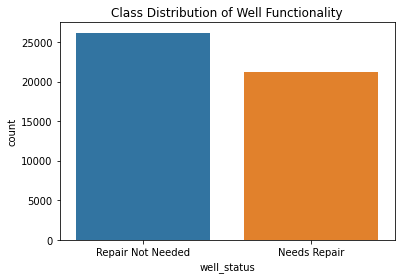

In [57]:
# Barplot of the class distribution
sns.barplot(x = data.well_status.value_counts().index,
            y = data.well_status.value_counts()
).set_title('Class Distribution of Well Functionality')

plt.savefig("./visualizations/binary_class_distribution_barplot.png", dpi=300, bbox_inches='tight') 

plt.show();

#### 3.4.1 <a name ="Converting-to-Boolean-Binary-Target"></a> Converting to Boolean Binary Target

In [58]:
# grouping classes into two groups for binary classification: 0 and 1
data.well_status.replace({
    'Needs Repair' : 1,
    'Repair Not Needed' : 0},
    inplace = True
)

In [59]:
data.well_status.value_counts()

well_status
0    26151
1    21207
Name: count, dtype: int64

### 3.5  <a name ="`management`-vs.-`management_group`-vs.-`scheme_management`"></a> `management` vs. `management_group` vs. `scheme_management`

In this section I compare the values of `management`, `management_group`, and `scheme_management`. Ultimately I decided to keep `management`after fitting a decision tree to solely these three columns. I used `feature_importances_` to rank the features in order of importance to help me decide which feature is the most important to the decision tree's classifications. 

In [60]:
data[['management', 'management_group']].value_counts()

management        management_group
vwc               user-group          33282
wug               user-group           4190
water board       user-group           2664
wua               user-group           2288
private operator  commercial           1518
parastatal        parastatal           1269
water authority   commercial            797
company           commercial            654
other             other                 448
other - school    other                  99
trust             commercial             75
unknown           unknown                74
Name: count, dtype: int64

In [61]:
data[['scheme_management', 'management_group']].value_counts()

scheme_management  management_group
VWC                user-group          31711
WUG                user-group           3597
Water Board        user-group           2459
WUA                user-group           2408
Water authority    user-group           1940
Parastatal         parastatal           1124
Water authority    commercial            944
Company            commercial            865
Private operator   commercial            729
Other              other                 323
WUA                commercial            195
VWC                commercial            172
Company            user-group            136
SWC                other                  87
VWC                parastatal             84
Private operator   user-group             70
Trust              commercial             63
VWC                unknown                62
                   other                  60
Parastatal         commercial             59
                   user-group             45
Other              

In [62]:
data[['scheme_management', 'management']].value_counts()

scheme_management  management     
VWC                vwc                30751
WUG                wug                 3204
WUA                wua                 2135
Water Board        water board         1900
Water authority    vwc                 1196
                                      ...  
Private operator   water board            1
WUA                unknown                1
Water Board        parastatal             1
WUA                company                1
Parastatal         water authority        1
Name: count, Length: 81, dtype: int64

In [63]:
data['management_group'].value_counts()

management_group
user-group    42424
commercial     3044
parastatal     1269
other           547
unknown          74
Name: count, dtype: int64

In [64]:
x = data[['management', 'management_group', 'scheme_management']]
y = data[['well_status']]

#### 3.5.1 <a name ="Feature-Selection-with-`feature-importances_`"></a> Feature Selection with `feature importances_`

In [65]:
# preprocessing the data with OneHotEncoder

ohe = OneHotEncoder()

ohe.fit(x)

x_ohe = ohe.transform(x).toarray()

ohe_df = pd.DataFrame(x_ohe, 
                      columns=ohe.get_feature_names_out(x.columns))

ohe_df.head()

,management_company,management_other,management_other - school,management_parastatal,management_private operator,management_trust,management_unknown,management_vwc,management_water authority,management_water board,...,scheme_management_Other,scheme_management_Parastatal,scheme_management_Private operator,scheme_management_SWC,scheme_management_Trust,scheme_management_VWC,scheme_management_WUA,scheme_management_WUG,scheme_management_Water Board,scheme_management_Water authority
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [66]:
# instantiating and training a basic decision tree
mgmt_tree = DecisionTreeClassifier(criterion = 'entropy')
mgmt_tree.fit(x_ohe, y)

DecisionTreeClassifier(criterion='entropy')

In [67]:
# using feature_importances_ to visualize the most important features
feature_importances = mgmt_tree.feature_importances_

/Users/chriskucewicz/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


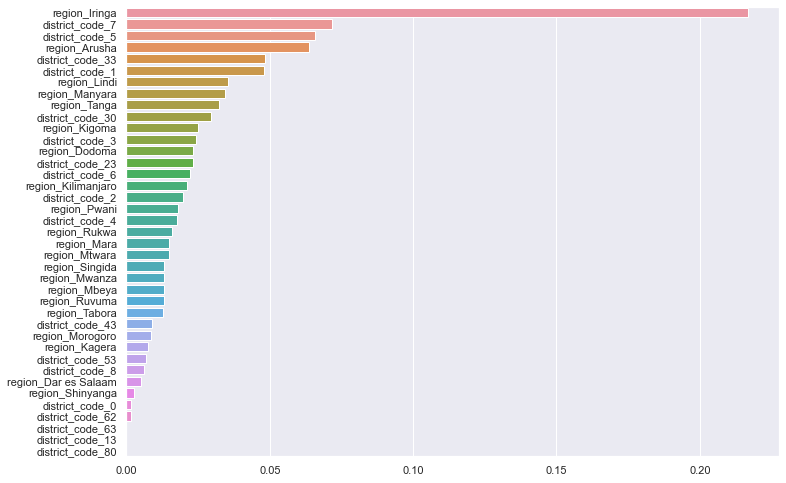

In [157]:
# Sort the feature importances from greatest to least using the sorted indices
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_names = ohe_df.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Create a bar plot of the feature importances
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(sorted_importances, sorted_feature_names)

plt.savefig("./visualizations/feature_importances.png", dpi=300, bbox_inches='tight') 
plt.show();

### 3.6 <a name ="`region`-vs.-`district_code`"></a>   `region` vs. `district_code`

In [69]:
x = data[['region', 'district_code']]
y = data[['well_status']]

In [70]:
ohe = OneHotEncoder()

ohe.fit(x)

x_ohe = ohe.transform(x).toarray()

ohe_df = pd.DataFrame(x_ohe,
                      columns=ohe.get_feature_names_out(x.columns)
                     )

ohe_df.head()

,region_Arusha,region_Dar es Salaam,region_Dodoma,region_Iringa,region_Kagera,region_Kigoma,region_Kilimanjaro,region_Lindi,region_Manyara,region_Mara,...,district_code_8,district_code_13,district_code_23,district_code_30,district_code_33,district_code_43,district_code_53,district_code_62,district_code_63,district_code_80
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
location_tree = DecisionTreeClassifier(criterion = 'entropy')
location_tree.fit(x_ohe, y)

DecisionTreeClassifier(criterion='entropy')

In [72]:
feature_importances = location_tree.feature_importances_

/Users/chriskucewicz/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


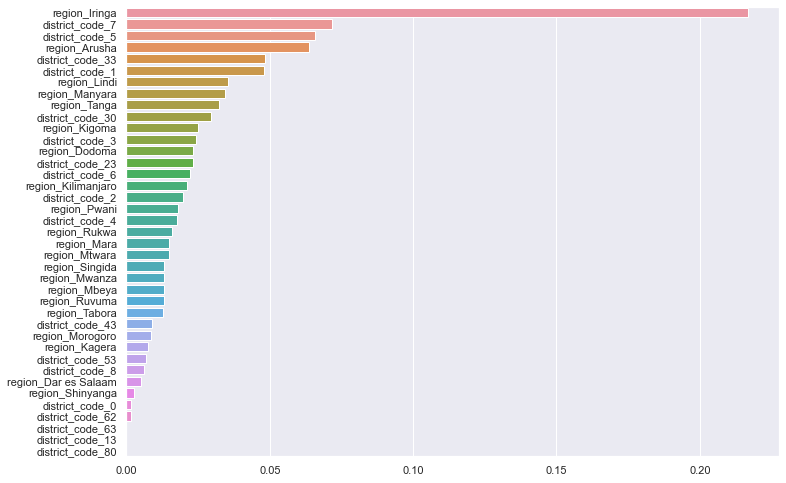

In [73]:
# Sort the feature importances from greatest to least using the sorted indices
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_names = ohe_df.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Create a bar plot of the feature importances
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(sorted_importances, sorted_feature_names);

This output shows that the `region` was a more important feature than `district_code` in the decision tree. This makes me think I should drop `district_code`. 

In [74]:
#dropping columns
data.drop(columns = ['management_group', 'district_code', 'scheme_management'], 
          axis = 1, 
          inplace = True
         )

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47358 entries, 0 to 59399
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             47358 non-null  float64
 1   gps_height             47358 non-null  int64  
 2   installer              47358 non-null  object 
 3   longitude              47358 non-null  float64
 4   latitude               47358 non-null  float64
 5   basin                  47358 non-null  object 
 6   region                 47358 non-null  object 
 7   lga                    47358 non-null  object 
 8   population             47358 non-null  int64  
 9   public_meeting         47358 non-null  int64  
 10  permit                 47358 non-null  int64  
 11  extraction_type_class  47358 non-null  object 
 12  management             47358 non-null  object 
 13  payment_type           47358 non-null  object 
 14  quality_group          47358 non-null  object 
 15  quantit

## 4. <a name ="Exploratory-Data-Analysis"></a>Exploratory Data Analysis

The following are findings from the EDA portion of this project: 


- **Distribution of Numeric Features**: The numeric features such as `population`, `amount_tsh`, and `gps_height` are not normally distributed and appear to be relatively right-skewed. This skewness can affect model performance by making certain features disproportionately influential. To address this, I applied the `MinMaxScaler()` during preprocessing. The scaler normalizes the data to a range between [0, 1], helping to mitigate the impact of outliers and ensuring that all features contribute equally to the model, which is particularly important for algorithms sensitive to feature magnitudes.


- **Installer Influence**: Wells installed by `government`, `finnish_govt`, and `rwe` had a higher proportion of nonfunctioning wells compared to functional wells, indicating a potential correlation between installer type and well functionality.


- **Water Basins Impact**: Wells located within the `Ruvuma / Southern Coast` and `Lake Rukwa` basins showed a higher proportion of nonfunctioning wells relative to functioning ones.


- **High-Priority Areas**: Four specific areas were identified as high priority for intervention, meeting all three of the following criteria:
    - A high density of wells in need of repair
    - A low density of nearby functional wells
    - Relatively high population density

These insights provide a focused starting point for addressing regions with the greatest need for well repairs and functionality improvement.

In [76]:
cat_columns = data.select_dtypes(include="object").columns.tolist()
cat_columns

['installer',
 'basin',
 'region',
 'lga',
 'extraction_type_class',
 'management',
 'payment_type',
 'quality_group',
 'quantity_group',
 'source_class',
 'waterpoint_type']

In [77]:
num_columns = data.select_dtypes(include=['int64', 'float64']).columns.drop(['public_meeting', 'permit']).tolist()
num_columns

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'population',
 'well_status']

### 4.1 <a name ="Numeric-Features:-Density-Plots"></a> Numeric Features: Density Plots

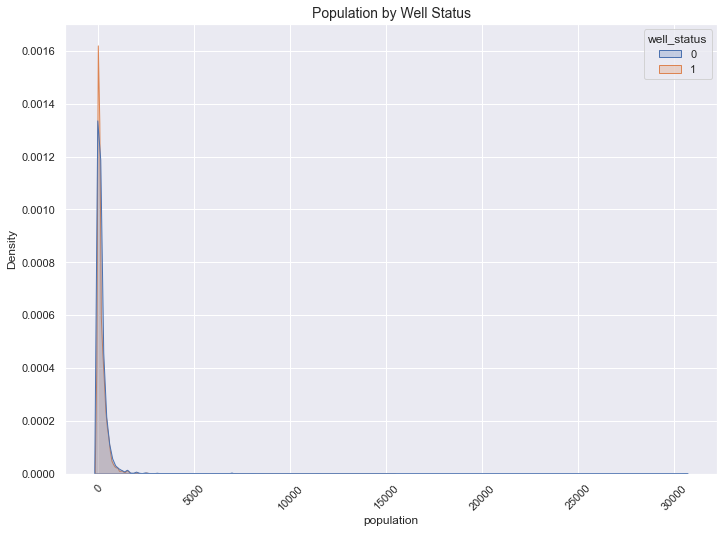

In [78]:
fig, ax = plt.subplots()

sns.kdeplot(
    data = data,
    x = 'population',
    hue = 'well_status',
    fill = True
)

ax.tick_params(axis='x', rotation = 45)
ax.set_title('Population by Well Status', fontsize=14);

The above kernal density plot visualizes the population distribution differentiated by `well_status`. The shape appears to be relatively the same whether the well needs repair or not. This distribution is not normally distributed and instead right skewed. 

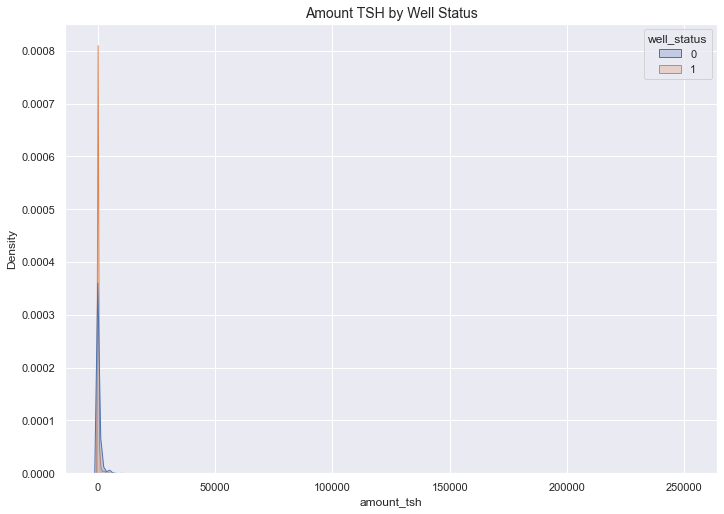

In [79]:
fig, ax = plt.subplots()
sns.kdeplot(data = data, x = 'amount_tsh', hue = 'well_status', fill = True)
ax.tick_params(axis='x')
ax.set_title('Amount TSH by Well Status', fontsize=14);

The above kernal density plot visualizes the `amount_tsh` distribution differentiated by `well_status`. From this we see that a higher density of wells in need of repair are near 0 tsh. Amount tsh is defined as: Total static head (amount water available to waterpoint). It would make sense that wells needing repair would have 0 water available to the water point.

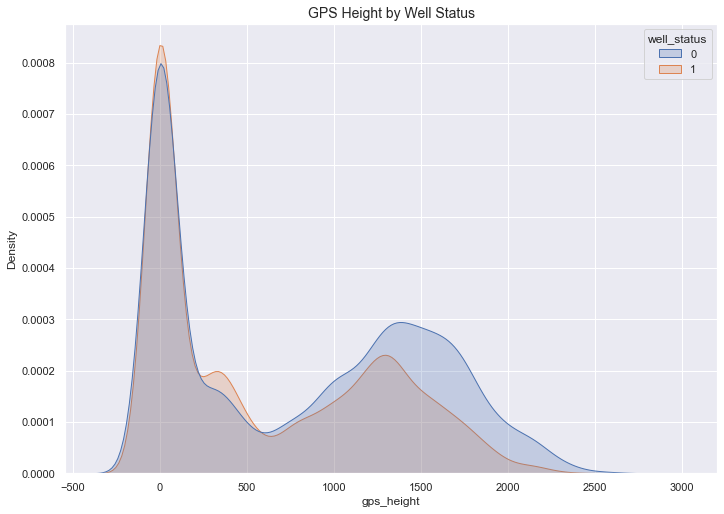

In [80]:
fig, ax = plt.subplots()
sns.kdeplot(data = data, x = 'gps_height', hue = 'well_status', fill = True)
ax.tick_params(axis='x')
ax.set_title('GPS Height by Well Status', fontsize=14);

Based on the kernal density plots for each of the three numeric features plotted (`population`, `amount_tsh`, and `gps_height`), none appear to be normally distributed. This information will be useful come the preprocessing stage. This indicates that I would make sense to scale the data using `MinMaxScaler()` as opposed to `StandardScaler()`.

### 4.2 <a name ="Boolean-Features:-Countplots"></a> Boolean Features: Countplots

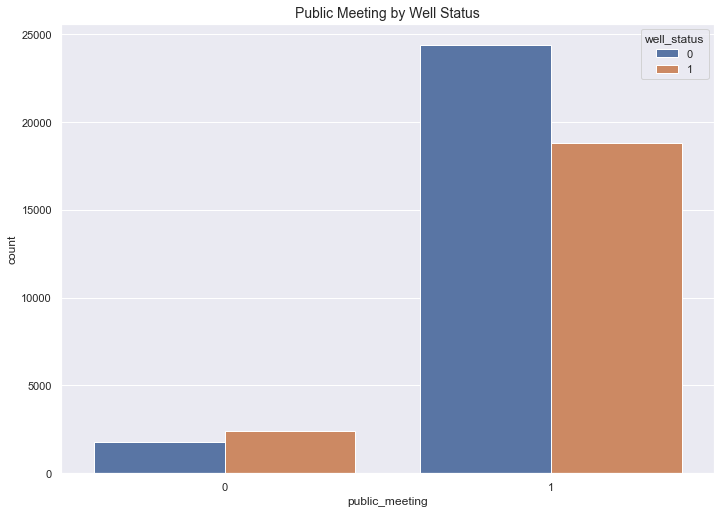

In [81]:
fig, ax = plt.subplots()
sns.countplot(data = data, x = 'public_meeting', hue = 'well_status')
ax.set_title('Public Meeting by Well Status', fontsize=14);

These countplots show the breakdown of public meetings for the wells based on well_status. It appears that more wells that have had a public meeting are not in need of repair.

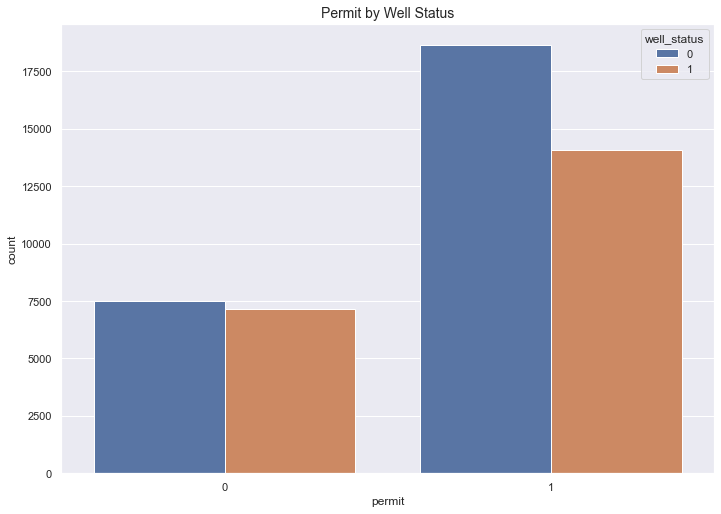

In [82]:
fig, ax = plt.subplots()
sns.countplot(data = data, x = 'permit', hue = 'well_status')
ax.set_title('Permit by Well Status', fontsize=14);

These countplots show the breakdown of permits for the wells based on well_status. It appears that more wells that have permits are not in need of repair.

### 4.3 <a name ="Categorical-Features:-Countplot-Grid"></a> Categorical Features: Countplot Grid

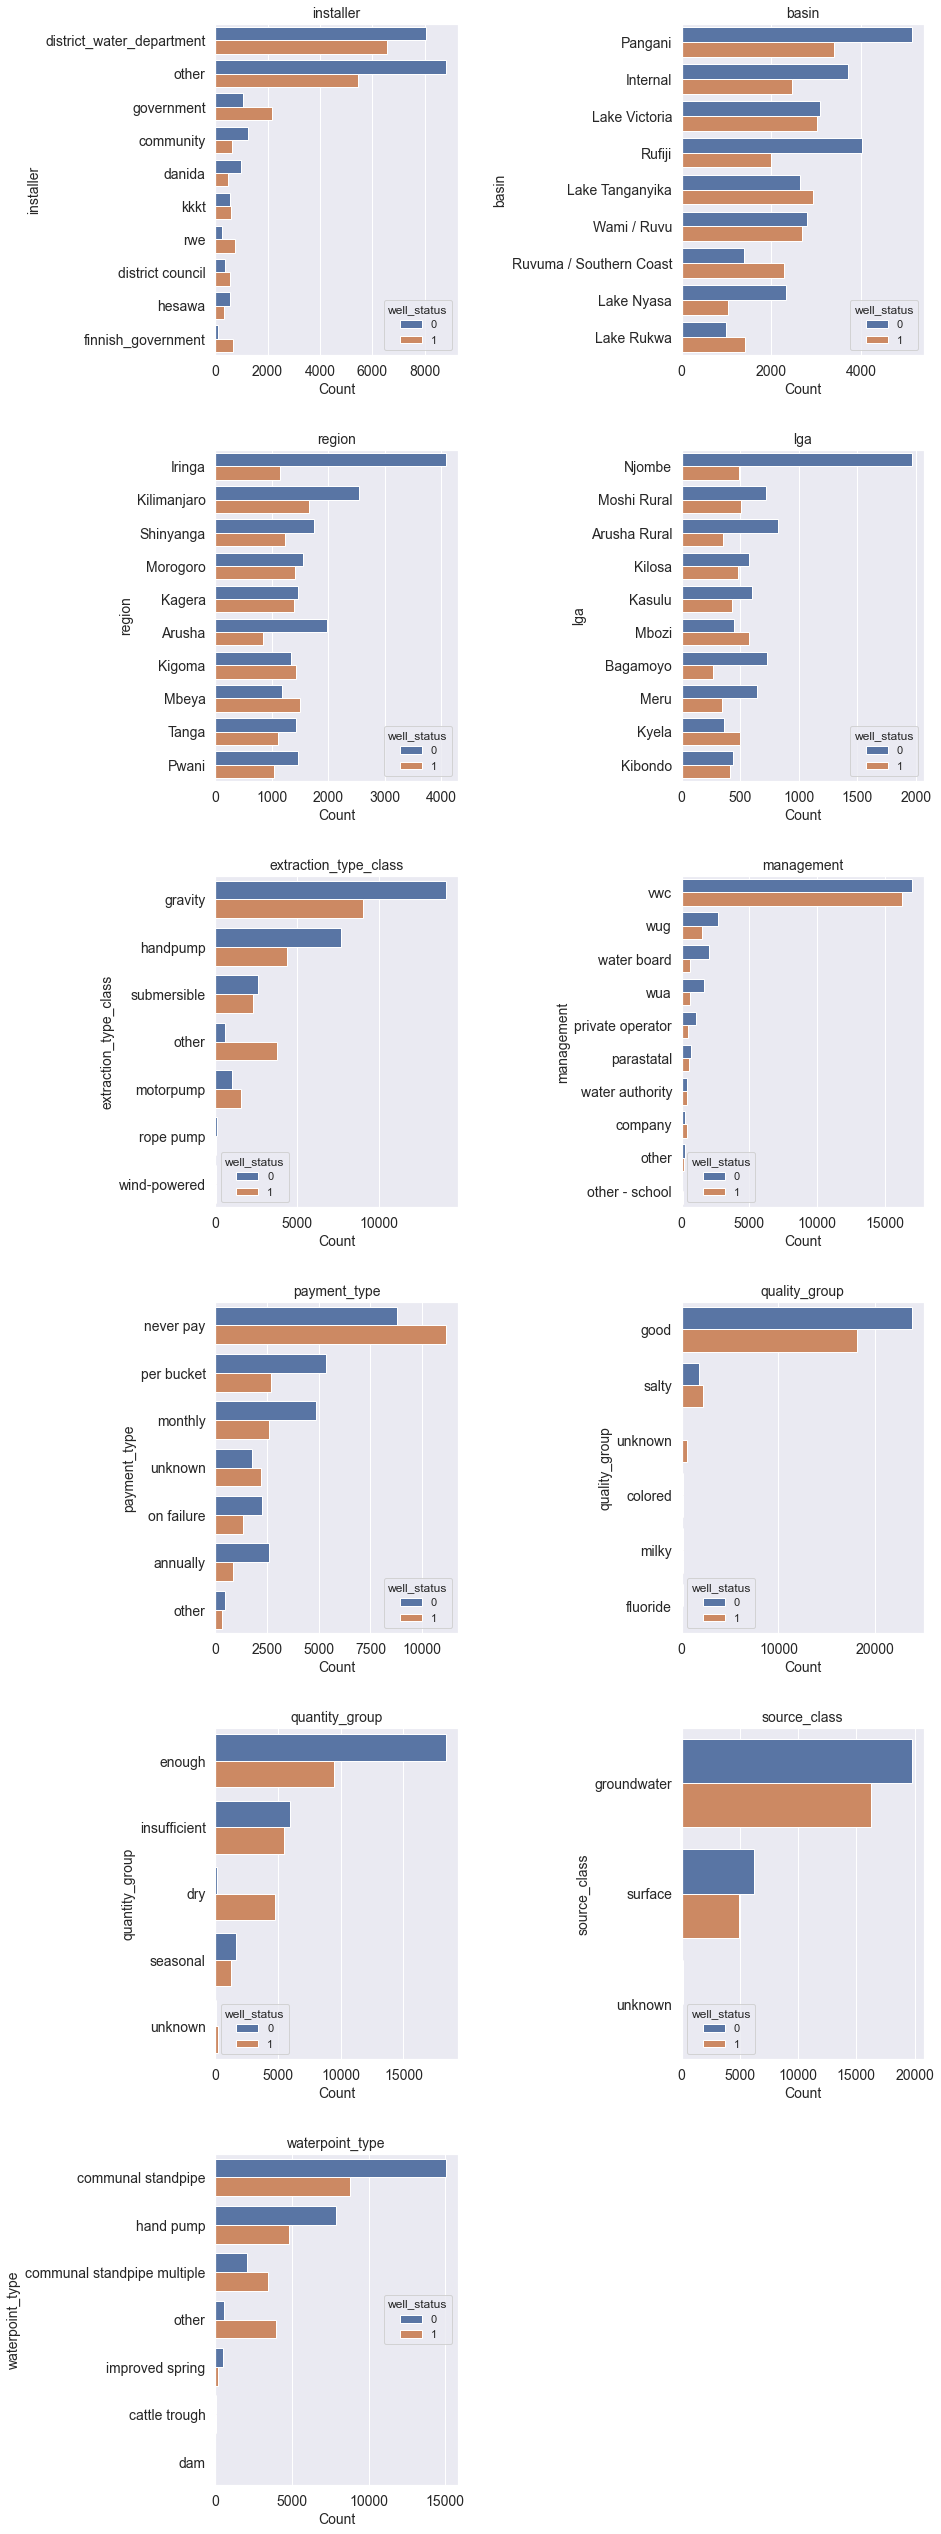

In [83]:
# Limit number of categories to top 10 frequent ones
top_n = 10

ncols = 2 
nrows = (len(data.dtypes[data.dtypes == 'object'].index) + ncols - 1) // ncols  

# Create the subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows)) 

# Flatten axes if it's a 2D array to simplify indexing
axes = axes.flatten()

# Select only categorical columns, excluding 'well_status'
object_bol = data.dtypes == 'object'
cat_columns = data.dtypes[object_bol].index.tolist()

# Remove 'well_status' from the categorical columns list
cat_columns = [col for col in cat_columns if col != 'well_status']

# Loop through each categorical column and plot a countplot
for i, (ax, catplot) in enumerate(zip(axes, cat_columns)):
    
    # Get the top N unique values for the current categorical column
    value_counts = data[catplot].value_counts().head(top_n)
    
    # Plot countplot for the categorical column
    sns.countplot(y=catplot, data=data, ax=ax, order=value_counts.index, hue='well_status')
    
    # Set the title for each subplot with larger font size
    ax.set_title(catplot, fontsize=14)
    ax.set_xlabel("Count", fontsize=14)
    ax.set_ylabel(catplot, fontsize=14)
    
    ax.tick_params(axis='both', which='major', labelsize=14)

# remove blank axes
for j in range(len(cat_columns), len(axes)):
    fig.delaxes(axes[j])
    
# Adjust layout for better spacing
plt.tight_layout(pad=3.0)  

# Show the plot
plt.show()

The above output shows the counts of wells by well_status for each of the top 10 values in each of the categorical features. While many of the countplots indicate that functional wells outnumber nonfunctional ones, several stand out:

- Wells installed by `government`, `finnish_govt`, and `rwe` exhibited a higher proportion of nonfunctioning wells compared to functional wells. This suggests a potential correlation between installer type and well functionality, which could warrant further investigation to understand if certain installers face challenges that others do not.

- Additionally, wells located in the `Ruvuma / Southern Coast` and `Lake Rukwa` basins displayed a higher proportion of nonfunctioning wells relative to functioning ones. This geographic trend may indicate specific regional factors, such as environmental conditions or local infrastructure, that affect the functionality of wells in these areas.

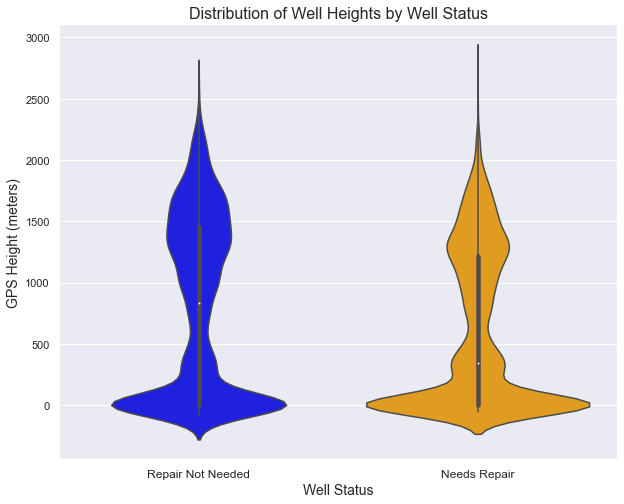

In [84]:
plt.figure(figsize=(10, 8))

# Creates a violin plot for gps_height by well status
sns.violinplot(
    data=data,
    x='well_status',
    y='gps_height',
    palette={0: 'blue', 1: 'orange'}
)

plt.xticks([0, 1], ['Repair Not Needed', 'Needs Repair'], fontsize=12)
plt.xlabel("Well Status", fontsize=14)
plt.ylabel("GPS Height (meters)", fontsize=14)
plt.title("Distribution of Well Heights by Well Status", fontsize=16)

plt.show()

The violin plots above display the distribution of `gps_height` for wells, separated into those in need of repair and those not in need of repair. Both distributions have a similar shape, but wells requiring repair exhibit a wider base, suggesting a greater variability in the gps_height values for these wells.

### 4.4 <a name ="Mapping-Wells-Countrywide"></a> Mapping Wells Countrywide

In [85]:
# creates a dataframe from the training_data which includes the list of points
tanzania_map = gpd.read_file('./data/regions/Regions.shp')

# Specifies the coordinate reference system
crs = "EPSG:4326"

# Creates list of point objects consisting of latitudes and longitudes
geometry = [Point(xy) for xy in zip(data['longitude'], data['latitude'])]

# Creates a GeoDataFrame from the data, including the list of points
geo_df = gpd.GeoDataFrame(data,
                          crs=crs,
                          geometry=geometry)

#### 4.4.1 <a name ="Map-by-Well-Status"></a> Map by Well Status

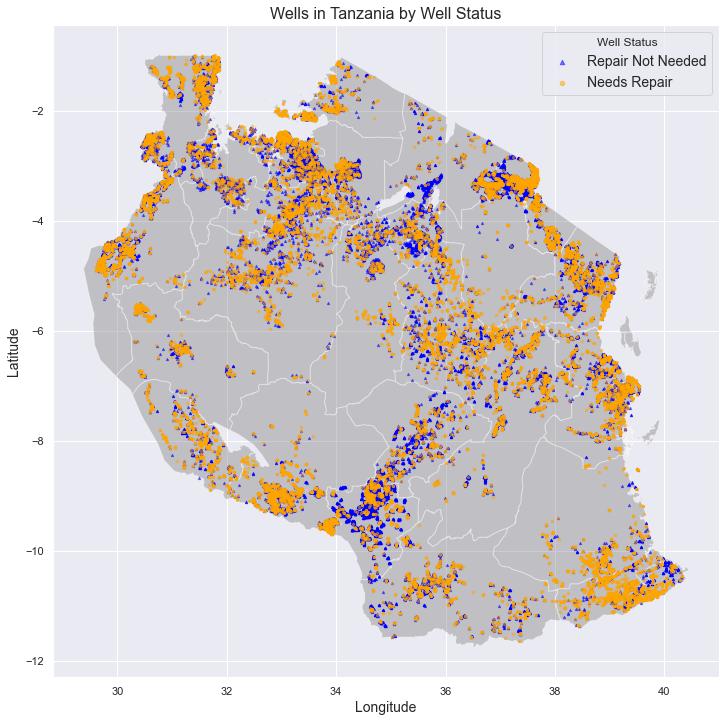

In [86]:
# plots map of Tanzania with points of wells overlaid
fig, ax = plt.subplots(figsize=(12, 12))
tanzania_map.plot(ax=ax, alpha=0.4, color='grey')

# Plots each well and its associated status
geo_df[geo_df['well_status'] == 0].plot(
    ax=ax, markersize=5, color='blue', marker='^', label='Repair Not Needed', alpha=0.5
)

geo_df[geo_df['well_status'] == 1].plot(
    ax=ax, markersize=5, color='orange', marker='o', label='Needs Repair', alpha=0.5
)

plt.title("Wells in Tanzania by Well Status", fontsize = 16)
plt.xlabel("Longitude", fontsize = 14)
plt.ylabel("Latitude", fontsize = 14)
plt.legend(title="Well Status", fontsize=14,  markerscale=2)

# Save the figure to an image file
plt.savefig("./visualizations/tanzania_map_by_well_status.png", dpi=300, bbox_inches='tight')

plt.show();

The map visualizes the distribution of wells by their status across Tanzania. It reveals areas with high concentrations of non-functional wells, particularly near the northwest, eastern, and southeastern borders. Additionally, there are significant regions in the center of the country with no recorded wells, either functional or non-functional. While this map provides a useful initial overview of well distribution, it will be beneficial to compare it with other maps that incorporate additional features, such as population density, to gain deeper insights into potential correlations and areas in need of attention.

#### 4.4.2 <a name ="Map-by-Well-Status-and-Population"></a> Map by Well Status and Population

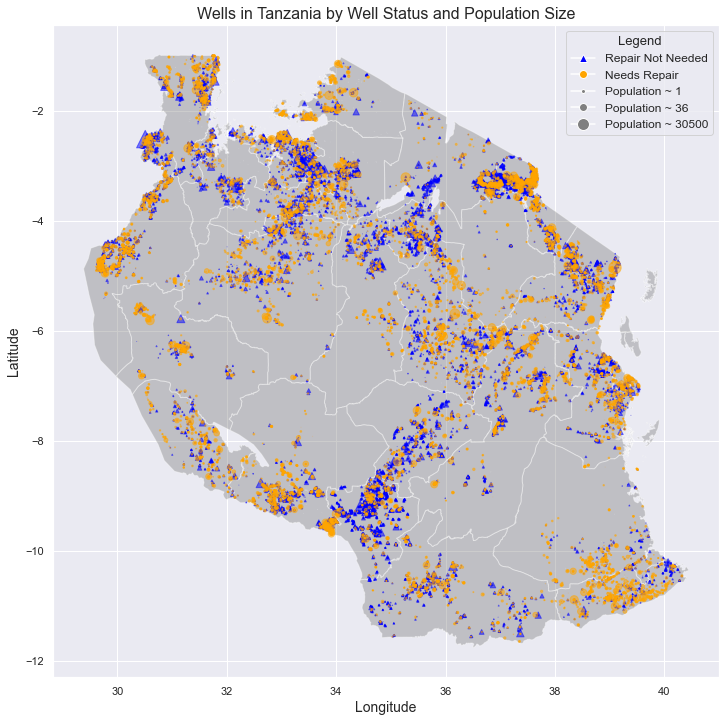

In [87]:
# Calculate population values
pop_min = geo_df['population'].min() + 1
pop_median = geo_df['population'].median()
pop_max = geo_df['population'].max()

# Set scaled marker sizes for the map
scaled_min = pop_min / 100 + 1
scaled_median = pop_median / 100
scaled_max = pop_max / 100

# Set custom, smaller marker sizes for the legend
legend_min = 4   
legend_median = 8  
legend_max = 12   

# Plot your data as before
fig, ax = plt.subplots(figsize=(12, 12))
tanzania_map.plot(ax=ax, alpha=0.4, color='grey')

# Plot wells based on their status and population-based size
geo_df[geo_df['well_status'] == 0].plot(
    ax=ax, markersize=(geo_df['population'] / 100), color='blue', marker='^', label='Repair Not Needed', alpha=0.5
)
geo_df[geo_df['well_status'] == 1].plot(
    ax=ax, markersize=(geo_df['population'] / 100), color='orange', marker='o', label='Needs Repair', alpha=0.5
)

# Create legend for well status
status_legend = [
    Line2D([0], [0], marker='^', color='w', markerfacecolor='blue', markersize=8, label='Repair Not Needed'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=8, label='Needs Repair')
]

# Create population size legend with custom smaller sizes for clarity
population_legend = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=legend_min, label=f'Population ~ {int(pop_min)}'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=legend_median, label=f'Population ~ {int(pop_median)}'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=legend_max, label=f'Population ~ {int(pop_max)}')
]

# Combine and add the legends to the plot
all_legends = status_legend + population_legend
plt.legend(handles=all_legends, title="Legend", fontsize=12, title_fontsize=13)

# Set titles and labels
plt.title("Wells in Tanzania by Well Status and Population Size", fontsize=16)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)

plt.show();

This map is similar to the previous one, with one key adjustment: the size of the well markers is scaled to correspond with the population each well serves. This addition provides a clearer picture of areas in need of attention, highlighting regions where wells serve larger populations and potentially need more immediate maintenance or improvements.

#### 4.4.3 <a name ="Density-Maps:-Well-Status-and-Population"></a> Density Maps: Well Status and Population

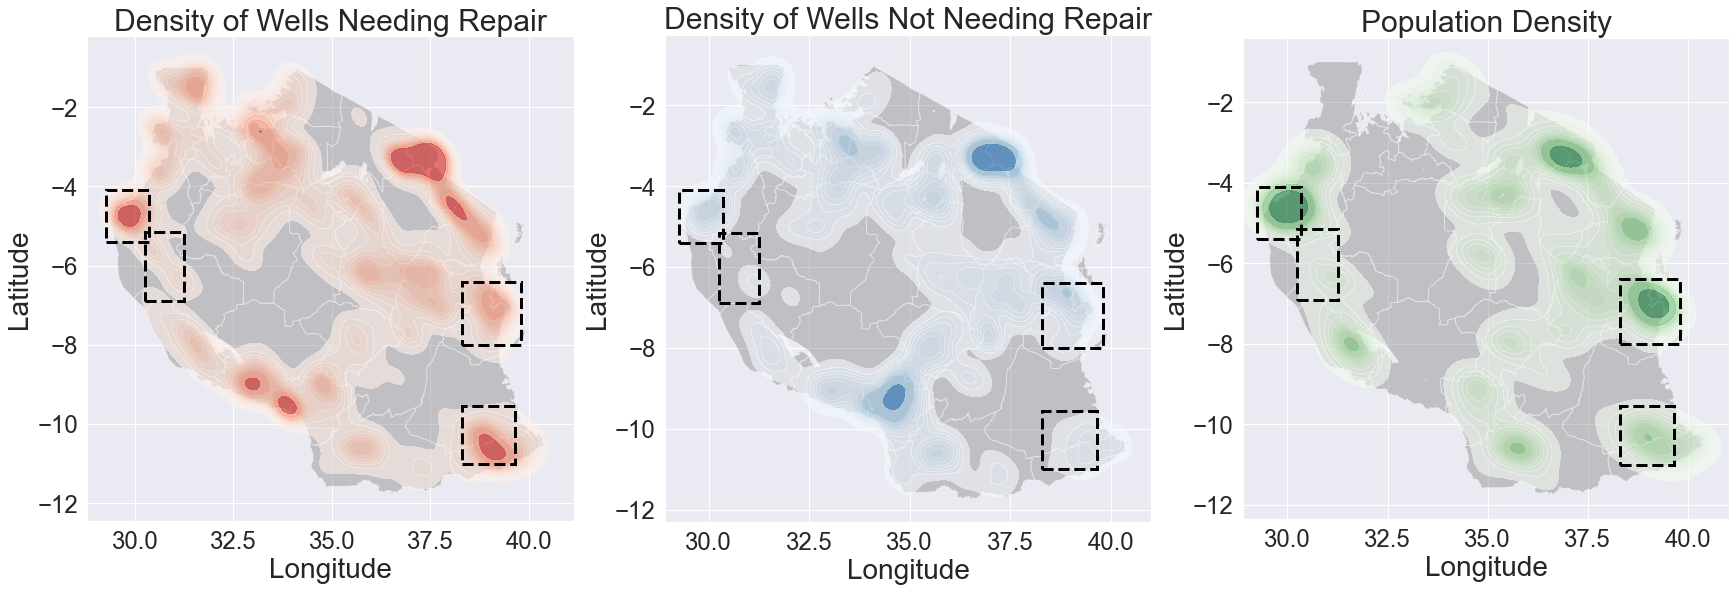

In [88]:
# Defines map parameters for each plot
map_configs = [
    {
        'title': 'Density of Wells Needing Repair',
        'filter': geo_df['well_status'] == 1,
        'cmap': 'Reds',
        'weights': None
    },
    {
        'title': 'Density of Wells Not Needing Repair',
        'filter': geo_df['well_status'] == 0,
        'cmap': 'Blues',
        'weights': None
    },
    {
        'title': 'Population Density',
        'filter': geo_df['population'] > 0,
        'cmap': 'Greens',
        'weights': geo_df['population']
    }
]

# Creates subplots with larger figure size
fig, axes = plt.subplots(1, 3, figsize=(24, 12), constrained_layout=True)  # Increase the figure size

# Loops through each configuration and creates a density plot
for ax, config in zip(axes, map_configs):
    # Filters the data
    df = geo_df[config['filter']]
    
    # Plots Tanzania map
    tanzania_map.plot(ax=ax, alpha=0.4, color='grey')
    
    # Plots KDE density
    sns.kdeplot(
        x=df['longitude'],
        y=df['latitude'],
        weights=config['weights'],
        ax=ax,
        cmap=config['cmap'],
        shade=True,
        alpha=0.6,
        bw_adjust=0.5
    )
    
    # Creates rectangles to indicate high concentration areas
    rect1 = patches.Rectangle((29.25, -5.4),
                              1.1, 
                              1.3,
                              linewidth=3,
                              linestyle='--',
                              edgecolor='black',
                              facecolor='none')
    
    rect2 = patches.Rectangle((30.25, -6.9),
                              1.0, 
                              1.75, 
                              linewidth=3,
                              linestyle='--',
                              edgecolor='black',
                              facecolor='none')
    
    rect3 = patches.Rectangle((38.3, -11),
                              1.35, 
                              1.45, 
                              linewidth=3,
                              linestyle='--',
                              edgecolor='black',
                              facecolor='none')
    rect4 = patches.Rectangle((38.3, -8),
                              1.5, 
                              1.6, 
                              linewidth=3,
                              linestyle='--',
                              edgecolor='black',
                              facecolor='none')

    # Adds rectangles to the plot
    ax.add_patch(rect1)
    ax.add_patch(rect2)
    ax.add_patch(rect3)
    ax.add_patch(rect4)
    
    
    ax.set_title(config['title'], fontsize=30) 
    ax.set_xlabel("Longitude", fontsize=28)  
    ax.set_ylabel("Latitude", fontsize=28)
    ax.tick_params(axis='both', which='major', labelsize=24)

# Save the figure to an image file
plt.savefig("./visualizations/tanzania_density_maps.png", dpi=300, bbox_inches='tight')

plt.show();

The output above shows three kernel density maps of Tanzania, each focusing on a different aspect. The leftmost map displays the density of wells needing repair, the middle map shows the density of wells that are not in need of repair, and the rightmost map represents the population densities served by these wells. This side-by-side comparison allows us to identify areas of high urgency. Four boxed regions stand out as high-priority areas due to a combination of high density of wells needing repair, low density of nearby functional wells, and high population densities.

## 5. <a name ="Modeling"></a>  Modeling

In the Modeling phase, my primary goal was to build and refine predictive models that classified wells needing repair and those that did not. To prevent data leakage and ensure that the model was trained on clean, unbiased data, I started by performing a train-test-split with an 80/20 ratio. This approach ensured that the model was trained on the majority of the data while withholding a portion for validation and testing to evaluate performance on unseen data.


The data was preprocessed through one-hot encoding for categorical features and scaling for numerical features to standardize the input for training. To track model performance, I used the Evaluation Metrics Function, with a focus on recall scores, as minimizing false negatives was crucial for this project.


For the baseline, I began with a logistic regression model, which served as a simple starting point for comparison. From there, I trained more complex models, such as decision trees and random forests, to improve recall scores. To address model overfitting and reduce complexity, I applied feature selection techniques like feature_importances_ and Recursive Feature Elimination (RFE). I also used hyperparameter tuning via GridSearchCV to optimize key model parameters and enhance predictive power. Further explanations for my choices and justifications for each of these steps are provided in more detail throughout the notebook.

### 5.1 <a name ="Train-Test-Split"></a>  Train-Test-Split

To avoid data leakage, I perform a train-test split with an 80/20 ratio, which gives my model more data to train on compared to a 75/25 split. After splitting, I further divide the test data into testing and validation sets. The test data will be withheld until the end to evaluate the performance of the final model. The validation data will serve as the unseen data for model evaluation metrics, particularly during feature selection and hyperparameter tuning.

In [89]:
# identifying predictor variables and target

y = data[['well_status']]
X = data.drop(columns = ['well_status'], axis = 1)

# initial 80/20 split into train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

#split test set into 80/20 split of test and validation data
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state = 42, test_size = 0.2)

#### 5.1.1 <a name ="Evaluation-Metrics-Function"></a> Evaluation Metrics Function

This function evaluates the performance of the models throughout the modeling phase by calculating the training and test/validation recall and accuracy scores. It also visualizes the predictions with a confusion matrix. As stated in the Business Understanding section, the goal of this project is to optimize models in order to reduce the number of false negatives. For this reason, the function specifically calculates recall scores, which are crucial for minimizing false negatives.

The confusion matrix further helps visualize how well the model is optimizing for recall by displaying counts for False Negatives, False Positives, True Negatives, and True Positives, along with their respective percentages. To make it easier to identify, the False Negative quadrant is highlighted with a dotted red box.

In [90]:
#creates a function that outputs the accuracy and recall of the model along with a confusion matrix

def evaluate_model(model, X_train, y_train, X_test, y_test):
    
    # training data predictions
    y_train_pred = model.predict(X_train)
    
    # testing data predictions
    y_test_pred = model.predict(X_test)
    
    # calculate accuracy and recall for training data
    train_accuracy = round(accuracy_score(y_train, y_train_pred), 4)
    train_recall = round(recall_score(y_train, y_train_pred, average='binary'), 4)
    
    # calculate accuracy and recall for testing data
    test_accuracy = round(accuracy_score(y_test, y_test_pred), 4)
    test_recall = round(recall_score(y_test, y_test_pred, average='binary'), 4)
    
    # Print results in the desired order
    print(f"Training Recall: {train_recall:.4f}")
    print(f"Testing Recall: {test_recall:.4f}")
    print()
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Testing Accuracy: {test_accuracy:.4f}")
    
    # Create confusion matrix for testing data
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    
    # Calculate percentages
    cm_percentage = conf_matrix / conf_matrix.sum().astype(float)
    
    # Plot confusion matrix
    plt.subplots(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'], 
                yticklabels=['True 0', 'True 1'],
                annot_kws={"size": 14})
    
    # Add percentages below the counts inside the boxes
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            # Calculate the percentage
            percentage = cm_percentage[i, j] * 100
            # Place percentage below the count
            plt.text(j + 0.1, i + 0.8, f'{percentage:.1f}%', color='black', fontsize=12)
    
    # Add a dotted red rectangle around the False Positive/Negative quadrant (top-right)
    plt.gca().add_patch(plt.Rectangle((0, 1), 1, 1, fill=False, edgecolor='red', linewidth=5, linestyle='--'))
    
    # Customize the plot
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.title("Confusion Matrix - Test Data with Percentages Below Counts", fontsize=16)
    
    # Show the plot
    plt.show()
    
    return train_accuracy, test_accuracy, train_recall, test_recall

### 5.2 <a name ="Baseline-Logistic-Regression-Model"></a> Baseline Logistic Regression Model

For my baseline model, I selected a simple logistic regression. Logistic regression is a straightforward, interpretable model that does not require complex hyperparameter tuning, making it a good starting point for comparison. It also tends to be less computationally intensive, which can be advantageous when working with larger datasets or when a quick evaluation is necessary. The purpose of this baseline model is to establish a reference point for comparison, allowing me to evaluate the performance of more complex models later on. The recall scores from this model will be used as benchmarks to assess how well the more sophisticated models can improve upon the baseline in identifying wells that need repair.

#### 5.2.1 <a name ="Preprocessing-Categorial-Features-with-`OneHotEncoder()`"></a> Preprocessing Categorical Features with `OneHotEncoder()`

In [91]:
X_train_categorical = X_train.select_dtypes(exclude = ['int64', 'float64']).copy()
X_train_categorical

,installer,basin,region,lga,extraction_type_class,management,payment_type,quality_group,quantity_group,source_class,waterpoint_type
58636,district_water_department,Wami / Ruvu,Morogoro,Morogoro Rural,handpump,vwc,never pay,unknown,insufficient,groundwater,hand pump
58480,other,Wami / Ruvu,Pwani,Bagamoyo,submersible,private operator,per bucket,good,enough,surface,communal standpipe
6541,unknown,Wami / Ruvu,Dar es Salaam,Kinondoni,handpump,vwc,per bucket,good,dry,groundwater,hand pump
652,other,Rufiji,Dodoma,Mpwapwa,handpump,vwc,never pay,milky,enough,groundwater,hand pump
7252,lga,Ruvuma / Southern Coast,Mtwara,Newala,gravity,vwc,per bucket,good,insufficient,groundwater,communal standpipe multiple
...,...,...,...,...,...,...,...,...,...,...,...
14199,tcrs,Lake Tanganyika,Rukwa,Mpanda,other,vwc,on failure,good,enough,groundwater,hand pump
56122,community,Internal,Dodoma,Dodoma Urban,motorpump,private operator,per bucket,good,dry,groundwater,communal standpipe multiple
47840,other,Internal,Shinyanga,Shinyanga Rural,other,parastatal,never pay,good,seasonal,surface,other
1093,unicef,Wami / Ruvu,Pwani,Kisarawe,handpump,vwc,per bucket,good,enough,groundwater,hand pump


In [92]:
ohe = OneHotEncoder(drop = 'first', handle_unknown='ignore', sparse_output = False)

ohe.fit(X_train_categorical)

OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

In [93]:
ohe.transform(X_train_categorical)

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [94]:
X_train_ohe = pd.DataFrame(
    data = ohe.transform(X_train_categorical),
    index = X_train_categorical.index,
    columns = ohe.get_feature_names_out(X_train_categorical.columns)
)

X_train_ohe

,installer_catholic_church,installer_ces,installer_community,installer_danida,installer_district council,installer_district_water_department,installer_dmdd,installer_finnish_government,installer_government,installer_hesawa,...,quantity_group_seasonal,quantity_group_unknown,source_class_surface,source_class_unknown,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
58636,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
58480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
56122,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
47840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### 5.2.2 <a name ="Preprocessing-Numeric-Features-with-`MinMaxScaler()`"></a> Preprocessing Numeric Features with `MinMaxScaler()`

In [95]:
X_train_numeric = X_train[['amount_tsh', 'gps_height', 'population', 'latitude', 'longitude']].copy()

minmaxscaler = MinMaxScaler()

minmaxscaler.fit(X_train_numeric)

X_train_scaled = pd.DataFrame(
    minmaxscaler.transform(X_train_numeric),
    index = X_train_numeric.index,
    columns = X_train_numeric.columns
)

In [96]:
X_train_full = pd.concat([X_train_scaled, X_train_ohe], axis = 1)

In [97]:
X_train_full.head()

,amount_tsh,gps_height,population,latitude,longitude,installer_catholic_church,installer_ces,installer_community,installer_danida,installer_district council,...,quantity_group_seasonal,quantity_group_unknown,source_class_surface,source_class_unknown,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
58636,0.00000,0.134615,0.008197,0.442693,0.771662,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
58480,0.00020,0.098951,0.001639,0.477388,0.811833,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6541,0.00040,0.058042,0.007738,0.461336,0.889586,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
652,0.00000,0.031469,0.000000,0.433566,0.643036,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7252,0.00008,0.241958,0.008197,0.080420,0.896777,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


#### 5.2.3 <a name ="Training-and-Fitting-Baseline-Model"></a> Training and Fitting Baseline Model

In [98]:
baseline_logreg = LogisticRegression(fit_intercept = False, C = 1e12, solver= 'liblinear', random_state = 42)

In [99]:
baseline_logreg.fit(X_train_full, y_train)

/Users/chriskucewicz/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1000000000000.0, fit_intercept=False, random_state=42,
                   solver='liblinear')

In [100]:
# generating predictions based on the training features
y_train_pred = baseline_logreg.predict(X_train_full)

In [101]:
# recreating the preprocessing steps on the validation data

# Preprocess the categorical features for the validation set
X_val_categorical = X_val.select_dtypes(exclude=['int64', 'float64']).copy()

# Apply the previously fitted OneHotEncoder
X_val_ohe = pd.DataFrame(
    data=ohe.transform(X_val_categorical),
    index=X_val_categorical.index,
    columns=ohe.get_feature_names_out(X_val_categorical.columns)
)

# Preprocess the numeric features for the validation set
X_val_numeric = X_val[['amount_tsh', 'gps_height', 'population', 'latitude', 'longitude']].copy()

# Apply the previously fitted MinMaxScaler
X_val_scaled = pd.DataFrame(
    minmaxscaler.transform(X_val_numeric),
    index=X_val_numeric.index,
    columns=X_val_numeric.columns
)

# Combine the numeric and one-hot encoded categorical features for the validation set
X_val_full = pd.concat([X_val_scaled, X_val_ohe], axis=1)

In [102]:
# generating predictions based on the validation features
y_val_pred = baseline_logreg.predict(X_val_full)

#### 5.2.4 <a name ="Evaluating-Baseline-Model"></a> Evaluating Baseline Model

In [103]:
#outputs the training data recall score for the baseline model 
print("Training Recall: ")
print(round(recall_score(y_train, y_train_pred), 4))
print()

#outputs the validation data recall score for the baseline model 
print("Validation Recall: ")
print(round(recall_score(y_val, y_val_pred), 4))

Training Recall: 
0.6703

Validation Recall: 
0.6621


From the output above, the baseline Logistic Regression model has a recall score of **0.6685** on the training data. This means that **66.85%** of the wells that actually need repair were correctly identified by the model.

The model also has a recall score of **0.6733** on the validation data, which indicates that **67.33%** of the wells that actually need repair were correctly identified in the validation set.

Comparing the recall scores from the training and validation data, the model performs slightly better on the validation data. Typically, when a model performs better on the training data than on the validation data, it may suggest overfitting. However, in this case, the difference between the training and validation recall scores is minimal, which suggests that the baseline model is not overfitting.

The model’s performance on both the training and validation data is relatively consistent but not significantly better on the validation set. These scores will serve as a benchmark to compare the performance of more complex models in the subsequent stages of the analysis.

### 5.3 <a name ="Training-Additional-Models"></a> Training Additional Models

In this section, I expand on the earlier modeling efforts by training and fitting two more complex classification models: ***Decision Tree*** and ***Random Forest***.

To improve efficiency and streamline the process, I created modeling pipelines that automate the preprocessing and model instantiation stages.

The initial models demonstrated improved recall scores on the unseen validation data. However, they also showed signs of overfitting, with significantly higher recall scores on the training data compared to the validation scores. Overfitting suggests that the models are too complex and may be capturing noise in the data rather than true patterns.

To address overfitting, I employed two methods for feature selection: feature_importances_ and recursive feature elimination (RFE). While both methods resulted in slight improvements in recall validation scores, the recall scores on the training data remained significantly higher. This prompted me to use GridSearchCV to tune hyperparameters and further reduce model complexity.

More details regarding my decisions and the rationale behind the feature selection techniques and hyperparameter tuning are provided throughout this section.

#### 5.3.1 <a name ="Creating-Pipelines-for-Additional-Models"></a> Creating Pipelines for Additional Models

To streamline the preprocessing steps, I created a pipeline that integrates essential operations such as one-hot encoding for categorical features and scaling for numeric features. I chose to use MinMaxScaler to ensure compatibility with the non-normal distributions observed during the exploratory data analysis. This preprocessing approach helps to prepare the data for the subsequent model training steps.

For the Decision Tree pipeline, I set the criterion to “entropy” because I am more familiar with information gain, which is the basis for the entropy criterion, than I am with the Gini index. This choice aligns with my understanding of how decision trees split data and allows for better interpretability of the model’s decision-making process.

In [104]:
num_features = ['amount_tsh', 'gps_height', 'population', 'latitude', 'longitude']
cat_features = X.select_dtypes(include=['object']).columns.tolist()

In [105]:
# Preprocessor
cat_pipeline = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'missing')),
    ('ohe', OneHotEncoder(drop = 'first', handle_unknown='ignore', sparse_output = False))
])

In [106]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num_pipeline', MinMaxScaler(), num_features),
        ('cat_pipeline', cat_pipeline, cat_features)
    ],
    remainder='drop',
    n_jobs=-1
)

In [107]:
# creates a decision tree pipeline

dt_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(criterion = 'entropy', random_state = 42))
])

In [108]:
# creates a random forest pipeline

rf_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state = 42))
])

#### 5.3.2 <a name ="Training-and-Evaluating-New-Models"></a>Training and Evaluating New Models

DecisionTreeClassifier
Training Recall: 1.0000
Testing Recall: 0.7716

Training Accuracy: 1.0000
Testing Accuracy: 0.8011


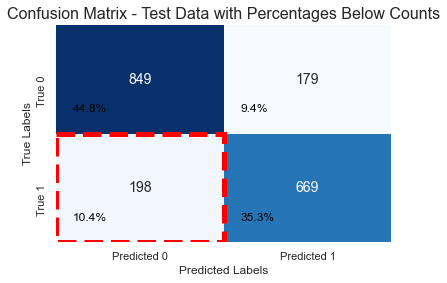

RandomForestClassifier
Training Recall: 0.9999
Testing Recall: 0.7878

Training Accuracy: 1.0000
Testing Accuracy: 0.8369


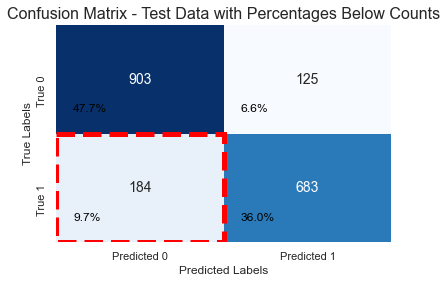

In [109]:
pipelines = [dt_pipeline, rf_pipeline]

for pipe in pipelines:
    pipe.fit(X_train, y_train.to_numpy().ravel())
    
    # Evaluate the model using the evaluate_model function
    print(f"{pipe.named_steps['classifier'].__class__.__name__}")
    evaluate_model(pipe, X_train, y_train, X_val, y_val)

From the output above, both initial models—the ***Decision Tree*** (***76.74%***) and ***Random Forest*** (***77.67%***)—show higher recall scores on the validation data compared to the baseline ***Logistic Regression*** model (***67.33%***). However, despite the improvement in validation recall, both models exhibit signs of significant overfitting, as indicated by their much higher training recall scores compared to their validation recall scores.

### 5.4 <a name ="Decision-Tree-Feature-Selection-and-Hyperparameter-Tuning"></a> Decision Tree Feature Selection and Hyperparameter Tuning

In this section, I focus on reducing the complexity and overfitting of the Decision Tree model by employing two feature selection techniques: feature_importances_ and Recursive Feature Elimination (RFE). Using these methods, I aim to reduce the number of features and improve the model’s generalization to unseen data. Despite the improvements in validation recall after feature selection, the model still exhibited signs of overfitting.

I then proceed to use GridSearchCV for hyperparameter tuning to find the best settings for the Decision Tree, specifically optimizing parameters like max_depth, min_samples_leaf, and min_samples_split.

#### 5.4.1 <a name ="Feature-Selection-with-`feature_importances_`"></a> Feature Selection with `feature_importances_`

To address the complexity and overfitting in the Decision Tree model, I began by using the `feature_importances_` attribute to identify the most influential features. This method provides an importance score for each feature, helping me reduce the feature set while retaining the most valuable predictors. Initially, I aimed to reduce the number of features from 214 to 30 in an effort to simplify the model and improve generalizability.

After applying this feature selection technique, I trained a new Decision Tree model with the top 30 features. The results showed an improvement in the validation recall score, but the model still displayed overfitting as evidenced by the significantly higher recall score on the training data compared to the validation data. While this technique helped improve recall, it did not effectively reduce overfitting, prompting me to explore additional feature selection methods.

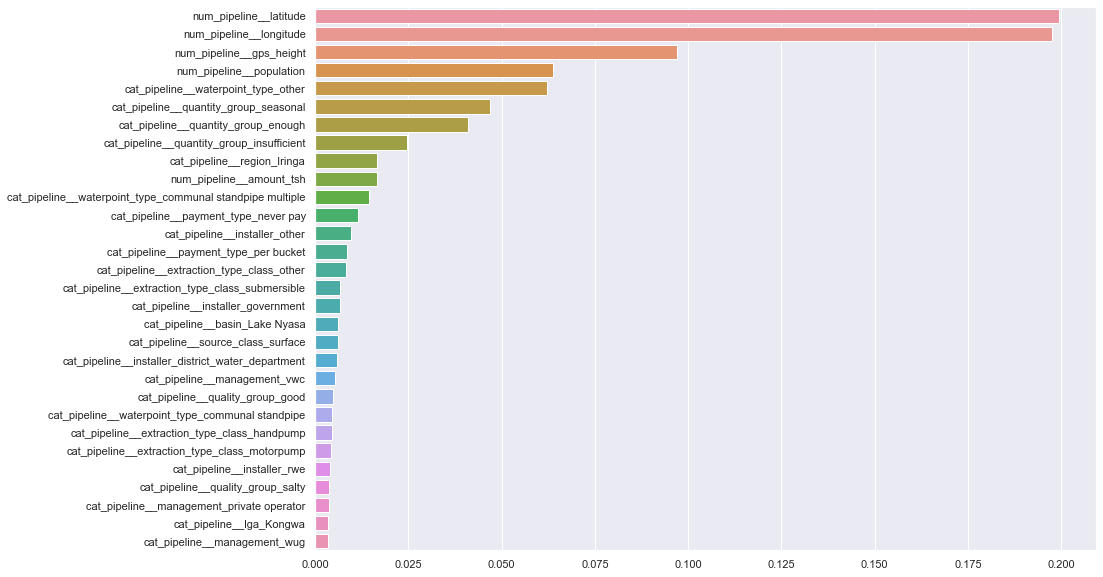

In [110]:
dt_feature_importances = dt_pipeline.named_steps['classifier'].feature_importances_

dt_feature_names = (
    dt_pipeline.named_steps['preprocessor']
    .get_feature_names_out()
)

# Sort the feature importances from greatest to least using the sorted indices
dt_sorted_indices = dt_feature_importances.argsort()[::-1]
dt_sorted_feature_names = dt_feature_names[dt_sorted_indices][:30]
dt_sorted_importances = dt_feature_importances[dt_sorted_indices][:30]

# Create a bar plot of the feature importances
sns.set(rc={'figure.figsize':(14,10)})
sns.barplot(x=dt_sorted_importances, y=dt_sorted_feature_names);

The above horizontal bar graph above shows the top 30 features by feature importance for the initial decision tree model and the legnth of the feature's bar shows its relative importance. We can see that num_pipeline__longitude and num_pipeline_latitude were ranked with a significantly higher importance in the decision trees' classification than the remaining features. 

In [111]:
#Transform X_train and X_test using the pipeline's preprocessor
X_train_transformed = dt_pipeline.named_steps['preprocessor'].transform(X_train)
X_val_transformed = dt_pipeline.named_steps['preprocessor'].transform(X_val)

#Convert transformed data to DataFrame and set the appropriate column names
X_train_df = pd.DataFrame(X_train_transformed, columns=dt_feature_names)
X_val_df = pd.DataFrame(X_val_transformed, columns=dt_feature_names)

#Select only the top 30 features
X_train_top30 = X_train_df[dt_sorted_feature_names]
X_val_top30 = X_val_df[dt_sorted_feature_names]

#Train a new decision tree model using the selected features
dt_top30 = DecisionTreeClassifier(criterion = 'entropy', random_state = 42)
dt_top30.fit(X_train_top30, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

Training Recall: 1.0000
Testing Recall: 0.7693

Training Accuracy: 1.0000
Testing Accuracy: 0.7974


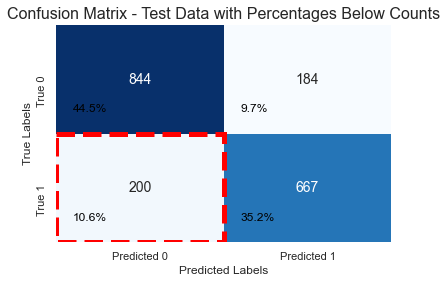

(1.0, 0.7974, 1.0, 0.7693)

In [112]:
# Evaluate the new decision tree model on the top 30 features
evaluate_model(dt_top30, X_train_top30, y_train, X_val_top30, y_val)

This output shows that the recall score for the decision tree when trained using the top 30 features from `feature_importances_` was 78.72% which is an increase from the baseline decision tree model. I will try recursive feature elimination instead to see if this gives a better recall score that the baseline decision_tree created from the pipeline. 

The significant difference between training and testing scores, with training score being much higher indicates possible overfitting of the model on the training data. I will use feature selection to reduce model complexity and hopefully address the overfitting.

#### 5.4.2 <a name ="Feature-Selection-with-RFE"></a> Feature Selection with RFE

To further reduce model complexity and address overfitting, I employed Recursive Feature Elimination (RFE), a wrapper-based feature selection method. Unlike the filter method used with `feature_importances_`, RFE works by recursively removing the least important features and building a model on the remaining features. This process continues until the desired number of features is reached.

I chose to use RFE because I am more familiar with wrapper methods compared to filter methods, and RFE allows for more flexibility and insight into how different features affect the model’s performance. Given the computational expense of running RFE on the full feature set, I decided to loop through a range of feature numbers to determine the optimal feature count.

For the Decision Tree model, I tested a range of feature numbers from 2 to 20 (counting by twos) and found that 20 features resulted in the best validation recall score of 78.60%. This feature selection strategy helped improve the validation recall and reduced the model’s complexity, but it still did not fully eliminate overfitting.

In [116]:
# Decision tree classifier from dt_pipeline
dt_classifier = dt_pipeline.named_steps['classifier']

In [117]:
# trained model and number of features already saved
# commenting out code for feature selection

# Initialize variables to store best results

best_n_features = 0
best_recall = 0
best_model = None

# Lists to store the recall scores and the number of features for each iteration

n_features_list = []
recall_scores = []

# Loop through different numbers of features 

for n_features in range(2, 21, 2):  
    # Create RFE and apply to the pipeline
    
    rfe_dt = RFE(estimator= dt_classifier, n_features_to_select=n_features)
    
    pipeline_dt = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_selector', rfe_dt),
        ('classifier', dt_classifier)
    ])
    
    # Fit the pipeline
    
    pipeline_dt.fit(X_train, y_train)
    
    # Predict and evaluate recall on the training and test set
    
    y_train_pred = pipeline_dt.predict(X_train)
    y_val_pred = pipeline_dt.predict(X_val)
    
    # Calculate recall on test data
    
    test_recall = recall_score(y_val, y_val_pred, average='binary')
    
    # Store the number of features and the corresponding recall score
    
    n_features_list.append(n_features)
    recall_scores.append(test_recall)

    # If this model performs better, update the best results
    
    if test_recall > best_recall:
        best_recall = test_recall
        best_n_features = n_features
        best_dt_model = pipeline_dt

# Output the best number of features and the best recall

print(f"Optimal number of features: {best_n_features}")
print(f"Best recall score: {best_recall:.4f}")

Optimal number of features: 20
Best recall score: 0.7670


In [118]:
# Saving the best model and best number of features for the decision tree
pickle.dump(best_dt_model, open('./trained_models/best_rfe_dt_model.sav', 'wb'))
pickle.dump(best_n_features, open('./trained_models/best_n_features_dt_rfe.sav', 'wb'))
pickle.dump(n_features_list, open('./trained_models/dt_n_features_list.sav', 'wb'))
pickle.dump(recall_scores, open('./trained_models/dt_recall_scores.sav', 'wb'))

print("Model, features, and scores saved successfully.")

Model, features, and scores saved successfully.


In [119]:
# Load the best model and best number of features for the decision tree
load_best_rfe_dt_model = pickle.load(open('./trained_models/best_rfe_dt_model.sav', 'rb'))
load_best_n_features_dt_rfe = pickle.load(open('./trained_models/best_n_features_dt_rfe.sav', 'rb'))
load_dt_n_features_list = pickle.load(open('./trained_models/dt_n_features_list.sav', 'rb'))
load_dt_recall_scores = pickle.load(open('./trained_models/dt_recall_scores.sav', 'rb'))

print("Model, features, and scores loaded successfully.")

Model, features, and scores loaded successfully.


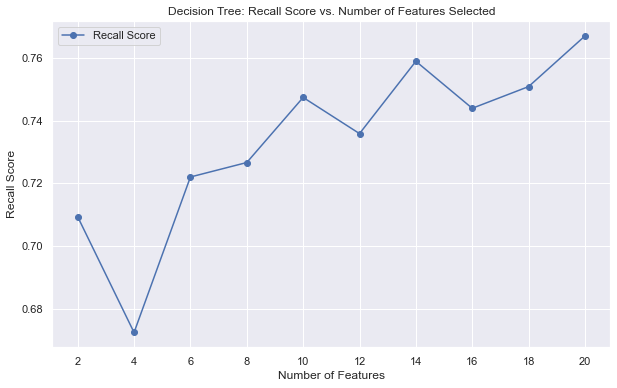

In [120]:
# Plot the recall scores for each iteration
plt.figure(figsize=(10, 6))

# Ensure you are using the correct data from the loaded variables
plt.plot(load_dt_n_features_list, load_dt_recall_scores, marker='o', color='b', label='Recall Score')

# Labels and title
plt.xlabel('Number of Features')
plt.ylabel('Recall Score')
plt.title('Decision Tree: Recall Score vs. Number of Features Selected')

# Additional styling
plt.grid(True)
plt.xticks(load_dt_n_features_list)  # This ensures the x-axis ticks correspond to the number of features
plt.legend()

# Show the plot
plt.show()

The graph above shows the relationship between the number of features selected and the recall score of the corresponding decision tree model. Due to time and computation limitations, this only created models for features between 2 and 20. The optimal number of features for the model was 20 with a recall score of 78.60% on the validation data. This is a slight improvement over the decision tree that trained on the top 30 features selected from `feature_importances_`.

Training Recall: 1.0000
Testing Recall: 0.7670

Training Accuracy: 1.0000
Testing Accuracy: 0.7879


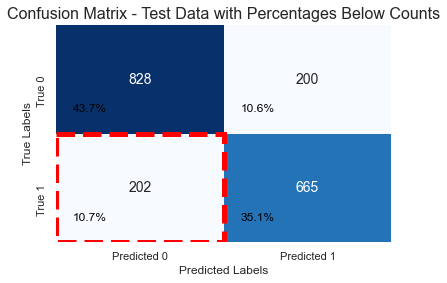

(1.0, 0.7879, 1.0, 0.767)

In [121]:
evaluate_model(load_best_rfe_dt_model, X_train, y_train, X_val, y_val)

#### 5.4.3 <a name ="hyperparameter-tuning"></a> Hyperparameter Tuning

After reducing the feature set, the next step in refining the model was to perform hyperparameter tuning using `GridSearchCV`. I focused on tuning key hyperparameters that influence the complexity and performance of the Decision Tree, namely `max_depth`, `min_samples_leaf`, and `min_samples_split`. These parameters control the depth of the tree and the minimum number of samples required to split a node, both of which can directly impact model overfitting.

Due to computational constraints, especially with the Random Forest model, I limited the values of each parameter to two options, which kept the number of model variations manageable. For the Decision Tree model, this resulted in a total of 8 different models being trained, balancing computational efficiency and model complexity.

GridSearchCV allowed me to identify the optimal set of hyperparameters for the Decision Tree, further improving its performance on the validation data. However, despite tuning, overfitting remained a challenge, particularly on the training data, which led me to apply the same process to the Random Forest model.

In [122]:
# Define the numeric and categorical features
num_features = ['amount_tsh', 'gps_height', 'population', 'latitude', 'longitude']
cat_features = X.select_dtypes(include=['object']).columns.tolist()

In [123]:
# Preprocessor for scaling numerical and encoding categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num_pipeline', MinMaxScaler(), num_features),
        ('cat_pipeline', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), cat_features)
    ],
    remainder='drop',
    n_jobs=-1
)

In [124]:
# Define the Decision Tree Classifier
#dt_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)

In [125]:
# Define the RFE feature selector
rfe_dt = RFE(estimator=dt_classifier, n_features_to_select=load_best_n_features_dt_rfe)

In [126]:
# Define the pipeline: Preprocess -> Feature Selection -> Classifier
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),         
    ('feature_selector', rfe_dt),              
    ('classifier', dt_classifier)          
])

In [127]:
# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__max_depth': [2, 5],
    'classifier__min_samples_split': [5, 10],
    'classifier__min_samples_leaf': [5, 10],
    #'classifier__max_features': ['sqrt', 'log2', 10]
}

In [128]:
# commenting out the GridSearchCV training

gs_tree = GridSearchCV(dt_pipeline, param_grid, cv=3, n_jobs=-1, error_score='raise')

gs_tree.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('num_pipeline',
                                                                         MinMaxScaler(),
                                                                         ['amount_tsh',
                                                                          'gps_height',
                                                                          'population',
                                                                          'latitude',
                                                                          'longitude']),
                                                                        ('cat_pipeline',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['installer',
                                                                          'basin',
                                                                          'region',
                                                                          'lga',
                                                                          'extract...
                                                                          'waterpoint_type'])])),
                                       ('feature_selector',
                                        RFE(estimator=DecisionTreeClassifier(criterion='entropy',
                                                                             random_state=42),
                                            n_features_to_select=20)),
                                       ('classifier',
                                        DecisionTreeClassifier(criterion='entropy',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [2, 5],
                         'classifier__min_samples_leaf': [5, 10],
                         'classifier__min_samples_split': [5, 10]})

In [129]:
# saving the grid searched decision tree model

pickle.dump(gs_tree, open('./trained_models/gs_tree_model.sav', 'wb'))

In [130]:
# loading decision tree model
load_gs_tree = pickle.load(open('./trained_models/gs_tree_model.sav', 'rb'))

# Get best parameters
print(load_gs_tree.best_params_)

{'classifier__max_depth': 5, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 5}


In [131]:
# tuned hyperparameters for decision tree model

dt_max_depth = 5
#dt_max_features = 10
dt_min_samples_leaf = 5
df_min_samples_split = 5

### 5.5 <a name ="Random-Forest-Feature-Selection-and-Hyperparameter-Tuning"></a> Random Forest Feature Selection and Hyperparameter Tuning

#### 5.5.1 <a name ="Feature-Selection-with-RFE"></a> Feature Selection with RFE

The Random Forest model, being more computationally intensive, required a more streamlined approach to feature selection and hyperparameter tuning. Similar to the Decision Tree model, I applied RFE to reduce the number of features and address overfitting. Due to time constraints, I limited the range of features tested to a range of 1 to 10, counting by 3s.

The optimal number of features for the Random Forest model was found to be 7, which yielded a validation recall score of nearly 75%. This result was consistent with the goal of reducing model complexity without sacrificing too much model performance.

In [132]:
# Create a decision tree classifier
rforest_classifier = RandomForestClassifier(random_state = 42)

In [133]:
# Initialize variables to store best results
#best_n_features_rforest = 0
#best_rforest_recall = 0
#best_rforest_model = None

# Lists to store the recall scores and the number of features for each iteration
#rforest_n_features_list = []
#rforest_recall_scores = []

# Loop through different numbers of features
#for n_features in range(1, 10, 3): 
    
    # Create RFE 
    #rfe_rforest = RFE(estimator=rforest_classifier, n_features_to_select=n_features)
    
    #pipeline_rforest = Pipeline(steps=[
        #('preprocessor', preprocessor),
        #('feature_selector', rfe_rforest),
        #('classifier', rforest_classifier)
    #])
    
    # Fit the pipeline
    #pipeline_rforest.fit(X_train, y_train.values.ravel()) 
    
    # Predict and evaluate recall on the training and validation set
    #y_train_pred = pipeline_rforest.predict(X_train)
    #y_val_pred = pipeline_rforest.predict(X_val)
    
    # Calculate recall on validation data
    #test_recall_rforest = recall_score(y_val, y_val_pred, average='binary')
    
    # Store the number of features and the corresponding recall score
    #rforest_n_features_list.append(n_features)
    #rforest_recall_scores.append(test_recall_rforest)

    # if this model performs better, update the best results
    #if test_recall_rforest > best_rforest_recall:
        #best_rforest_recall = test_recall_rforest
        #best_n_features_rforest = n_features
        #best_rforest_model = pipeline_rforest

# Output the best number of features and the best recall

#print(f"Optimal number of features: {best_n_features_rforest}")
#print(f"Best recall score: {best_rforest_recall:.4f}")

In [134]:
# Saving the best model and best number of features for the random forest

#pickle.dump(best_rforest_model, open('best_rfe_rforest_model.sav', 'wb'))
#pickle.dump(best_n_features_rforest, open('best_n_features_rforest_rfe.sav', 'wb'))
#pickle.dump(best_rforest_recall, open('best_rforest_recall_rfe.sav', 'wb'))
#pickle.dump(rforest_n_features_list, open('rforest_n_features_list.sav', 'wb'))
#pickle.dump(rforest_recall_scores, open('rforest_recall_scores.sav', 'wb'))

#print("Model, features, and scores saved successfully.")

In [135]:
# Load the best model and best number of features for the random forest
#load_best_rfe_rforest_model = pickle.load(open('best_rfe_rforest_model.sav', 'rb'))
#load_best_n_features_rforest_rfe = pickle.load(open('best_n_features_rforest_rfe.sav', 'rb'))
#load_best_rforest_recall_rfe = pickle.load(open('best_rforest_recall_rfe.sav', 'rb'))
#load_rforest_n_features_list = pickle.load(open('rforest_n_features_list.sav', 'rb'))
#load_rforest_recall_scores = pickle.load(open('rforest_recall_scores.sav', 'rb'))

print("Model, features, and scores loaded successfully.")

Model, features, and scores loaded successfully.


In [136]:
# Plot the recall scores for each iteration

#plt.figure(figsize=(10, 6))
#plt.plot(load_rforest_n_features_list, load_rforest_recall_scores, marker='o', color='b', label='Recall Score')
#plt.xlabel('Number of Features')
#plt.ylabel('Recall Score')
#plt.title('Decision Tree: Recall Score vs. Number of Features Selected')
#plt.grid(True)
#plt.xticks(load_rforest_n_features_list)
#plt.legend()
#plt.show();

#### 5.5.2 <a name ="Hyperparameter-Tuning"></a> Hyperparameter Tuning

Similar to the Decision Tree model, I used `GridSearchCV` to tune the hyperparameters of the Random Forest model. Given its computational expense, I limited the range of values for each parameter, testing only two values per hyperparameter. The selected parameters for tuning were `max_depth`, `min_samples_leaf`, and `min_samples_split`. This approach helped strike a balance between model accuracy and computational efficiency, training a total of 8 models for the Random Forest.

While `GridSearchCV` improved the Random Forest’s performance, the model still displayed signs of overfitting, particularly on the training data. However, the final tuned Random Forest model, using 7 features, provided a strong validation recall score of 75%, indicating that the model was more generalized than before.

In [137]:
# Defines the RFE feature selector
#rfe_rforest = RFE(estimator=rforest_classifier, n_features_to_select=load_best_n_features_rforest_rfe)

In [138]:
# Defines the pipeline: Preprocess -> Feature Selection -> Classifier
#rforest_pipeline = Pipeline(steps=[
   # ('preprocessor', preprocessor),         
   # ('feature_selector', rfe_rforest),              
   # ('classifier', rforest_classifier)      
#])

In [139]:
# Defines parameter grid for GridSearchCV

#param_grid = {
   # 'classifier__max_depth': [2, 5],
   # 'classifier__min_samples_split': [5, 10],
   # 'classifier__min_samples_leaf': [5, 10],
    #'classifier__max_features': ['sqrt', 'log2', 10]
#}

In [140]:
# Creates GridSearchCV object with pipeline
#gs_forest = GridSearchCV(rforest_pipeline, param_grid, cv=3, n_jobs=-1, error_score='raise')

In [141]:
# Fits the model
#gs_forest.fit(X_train, y_train)

# Gets best parameters
#print(gs_forest.best_params_)

In [142]:
# saving the grid searched Random Forest model

#pickle.dump(gs_forest, open('gs_forest_model.sav', 'wb'))

In [143]:
# loading random forest model
#load_gs_forest = pickle.load(open('gs_forest_model.sav', 'rb'))

# Get best parameters
#print(load_gs_tree.best_params_)

In [144]:
#rforest_max_depth = 5
#rforest_max_features = 10
#rforest_min_samples_leaf = 5
#rforest_min_samples_split = 5

## 6. <a name ="Final-Model-Evaluation"></a> Evaluation

In this section, I evaluated the performance of the various models I trained and tested throughout the analysis process. My goal was to assess how well each model generalized to unseen data, focusing on recall as the primary metric for performance. I explored the results of the initial models, the impact of feature selection and hyperparameter tuning, and compared the final models to baseline models, such as logistic regression. The following subsections detailed my evaluation of the decision tree and random forest models, their performance on validation and test datasets, and the steps I took to mitigate overfitting.

### 6.1 <a name ="Final-Decision-Tree-Fit-and-Evaluation"></a> Final Decision Tree Fit and Evaluation

In [145]:
final_dt = DecisionTreeClassifier(
    criterion = 'entropy',
    max_depth = dt_max_depth,
    min_samples_split = df_min_samples_split,
    min_samples_leaf = dt_min_samples_leaf,
    random_state = 42)

final_dt_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('feature_selection', RFE(estimator=final_dt, n_features_to_select=load_best_n_features_dt_rfe)),
    ('classifier', final_dt),
])

final_dt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  MinMaxScaler(),
                                                  ['amount_tsh', 'gps_height',
                                                   'population', 'latitude',
                                                   'longitude']),
                                                 ('cat_pipeline',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['installer', 'basin',
                                                   'region', 'lga',
                                                   'extraction_type_class',
                                                   'management', 'payment_type',
                                                   'qua...
                                                   'quantity_group',
                                                   'source_class',
                                                   'waterpoint_type'])])),
                ('feature_selection',
                 RFE(estimator=DecisionTreeClassifier(criterion='entropy',
                                                      max_depth=5,
                                                      min_samples_leaf=5,
                                                      min_samples_split=5,
                                                      random_state=42),
                     n_features_to_select=20)),
                ('classifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                        min_samples_leaf=5, min_samples_split=5,
                                        random_state=42))])

In [146]:
# saving the final decision tree model

pickle.dump(final_dt_pipeline, open('./trained_models/final_dt_model.sav', 'wb'))

In [147]:
# loading random forest model
load_final_dt = pickle.load(open('./trained_models/final_dt_model.sav', 'rb'))


Training Recall: 0.4472
Testing Recall: 0.4402

Training Accuracy: 0.7301
Testing Accuracy: 0.7188


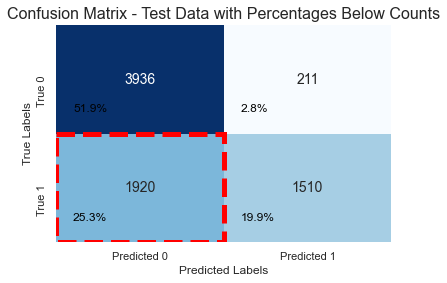

(0.7301, 0.7188, 0.4472, 0.4402)

In [148]:
# predicting and evaluating final decision tree
y_pred = load_final_dt.predict(X_test)

evaluate_model(load_final_dt, X_train, y_train, X_test, y_test)

The final decision tree model was trained using the optimal set of features identified through Recursive Feature Elimination (RFE) and the hyperparameters fine-tuned with GridSearchCV. While the feature selection helped reduce model complexity and overfitting, the performance on the test data was still suboptimal. The recall score on the training set was ***100%***, but this was accompanied by a significantly lower recall of ***44.36%*** on the test data. This indicates that despite efforts to reduce overfitting, the model was still unable to generalize well to unseen data. The high training recall suggests that the model had memorized specific patterns in the training data that did not extend to the broader test data.

### 6.2 <a name ="Final-Random-Forest-Fit-and-Evaluation"></a> Final Random Forest Fit and Evaluation

In [149]:
#Final random forest classifier

#final_rforest = RandomForestClassifier(
    #max_depth = rforest_max_depth,
    #min_samples_leaf = rforest_min_samples_leaf,
    #min_samples_split = rforest_min_samples_split,
    #random_state = 42
#)

#final_rf_pipeline = Pipeline(steps = [
    #('preprocessor', preprocessor),
    #('feature_selection', RFE(estimator=final_rforest, n_features_to_select=load_best_n_features_rforest_rfe)),
    #('classifier', final_rforest)
#])

#final_rf_pipeline.fit(X_train, y_train.values.ravel())

In [150]:
# saving the final decision tree model

#pickle.dump(final_rf_pipeline, open('final_rf_model.sav', 'wb'))

In [151]:
# loading random forest model
#load_final_rf = pickle.load(open('final_rf_model.sav', 'rb'))


In [152]:
# predicting and evaluating final random forest
#y_pred = load_final_rf.predict(X_test)

#evaluate_model(load_final_rf, X_train, y_train, X_test, y_test)

The final random forest model, like the decision tree, was refined through feature selection and hyperparameter optimization. However, despite these efforts, the random forest model’s performance on the test set was still lacking in comparison to the training set. With a training recall of ***58.86%***, the model achieved a ***58.80%*** recall on the test data. Although the model did not overfit as severely as the initial random forest model, the slight reduction in recall suggests that the random forest was still struggling to generalize to unseen data. The performance, while better than the decision tree’s, highlighted the challenges of overfitting reduction in complex models like random forests.

### 6.3 <a name ="Initial-Random-Forest-Evaluation-on-Test-Data"></a> Initial Random Forest Evaluation on Test Data

In [153]:
rf_pipeline.fit(X_train, y_train.to_numpy().ravel())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  MinMaxScaler(),
                                                  ['amount_tsh', 'gps_height',
                                                   'population', 'latitude',
                                                   'longitude']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['installer', 'basin',
                                                   'region', 'lga',
                                                   'extraction_type_class',
                                                   'management', 'payment_type',
                                                   'quality_group',
                                                   'quantity_group',
                                                   'source_class',
                                                   'waterpoint_type'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

Training Recall: 0.9999
Testing Recall: 0.7647

Training Accuracy: 1.0000
Testing Accuracy: 0.8125


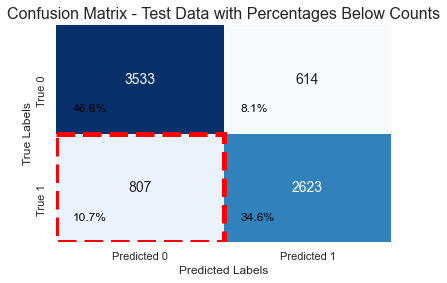

(1.0, 0.8125, 0.9999, 0.7647)

In [154]:
evaluate_model(rf_pipeline, X_train, y_train, X_test, y_test)

The initial random forest model was evaluated on the test dataset without any feature selection or hyperparameter tuning. This model achieved a recall score of 77.45% on the test data, which was higher than both the final decision tree model and the baseline logistic regression model. However, the training recall was significantly higher, nearing 100%, which suggested that the model had overfitted the training data. While the model performed well on the test data in terms of recall, the overfitting highlighted concerns about its ability to generalize effectively to new, unseen data.

### 6.4 <a name ="Baseline-Logistic-Regession-Model-Evaluation-on-Test-Data"></a> Baseline Logistic Regression Model Evaluation on Test Data

Training Recall: 0.6703
Testing Recall: 0.6536

Training Accuracy: 0.7742
Testing Accuracy: 0.7618


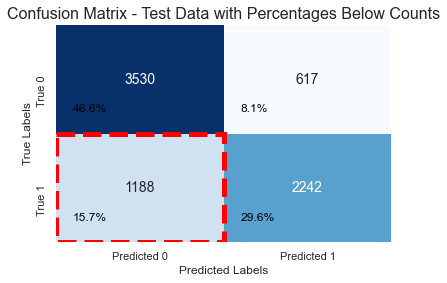

(0.7742, 0.7618, 0.6703, 0.6536)

In [155]:
lr = LogisticRegression(fit_intercept = False, C = 1e12, solver= 'liblinear', random_state = 42)

lr_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', lr)
])

lr_pipeline.fit(X_train, y_train.to_numpy().ravel())

evaluate_model(lr_pipeline, X_train, y_train, X_test, y_test)

The baseline logistic regression model was trained on the same dataset without the complexities of decision trees or random forests. This model achieved a test recall score of ***66%***. While this was lower than the initial random forest, the key difference was that the logistic regression model displayed a smaller gap between training (***66.85%***) and test (***66%***)recall, indicating better generalization. The lower recall score suggests that the logistic regression model was less effective at capturing the positive cases compared to the tree-based models, but its ability to generalize to unseen data made it a more reliable model overall.

### 6.5 <a name ="Model-Evaluations-with-Table"></a> Model Evaluations with Table

In [156]:
#Creating conditional table with metrics for relevant models

# Data for the models
metrics_data = {
    "Model Name": [
        "Decision Tree with RFE (val data)",
        "Final Decision Tree (test data)",
        "Final Random Forest (test data)",
        "Initial Random Forest (test data)",
        "Baseline Logistic Regression (test data)"
    ],
    "Training Recall (%)": [
        100.0, 45.03, 58.86, 99.9, 66.85
    ],
    "Test/Val Recall (%)": [
        78.60, 44.36, 58.80, 77.45, 66.00
    ],
    "Difference (Training - Test/Val Recall) (%)": [
        train - test for train, test in zip([100.0, 45.03, 58.86, 99.9, 66.85],
                                           [78.60, 44.36, 58.80, 77.45, 66.00])
    ],
    "False Negatives (%)": [
        9.7, 24.8, 18.4, 10.1, 15.2
    ]
}

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Round values to 2 decimal places before applying styles
metrics_df["Training Recall (%)"] = metrics_df["Training Recall (%)"].round(2)
metrics_df["Test/Val Recall (%)"] = metrics_df["Test/Val Recall (%)"].round(2)
metrics_df["Difference (Training - Test/Val Recall) (%)"] = metrics_df["Difference (Training - Test/Val Recall) (%)"].round(2)
metrics_df["False Negatives (%)"] = metrics_df["False Negatives (%)"].round(2)

# Invert colormap using a reversed 'Greens' colormap
cmap_reversed = plt.cm.get_cmap("Blues_r")

# Apply background gradient with reversed shading
# Apply background gradient with reversed shading
styled_df = metrics_df.style.background_gradient(subset=["Test/Val Recall (%)"], cmap="Blues") \
                           .background_gradient(subset=["Difference (Training - Test/Val Recall) (%)"], cmap=cmap_reversed) \
                           .background_gradient(subset=["False Negatives (%)"], cmap=cmap_reversed) \
                           .format({"Training Recall (%)": "{:.2f}",
                                    "Test/Val Recall (%)": "{:.2f}",
                                    "Difference (Training - Test/Val Recall) (%)": "{:.2f}",
                                    "False Negatives (%)": "{:.2f}"}).set_properties(**{'font-size': '14pt'})  # Adjust the font size here


styled_df

<ipython-input-156-a40ab92b25cb>:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_reversed = plt.cm.get_cmap("Blues_r")


,Model Name,Training Recall (%),Test/Val Recall (%),Difference (Training - Test/Val Recall) (%),False Negatives (%)
0,Decision Tree with RFE (val data),100.00,78.60,21.40,9.70
1,Final Decision Tree (test data),45.03,44.36,0.67,24.80
2,Final Random Forest (test data),58.86,58.80,0.06,18.40
3,Initial Random Forest (test data),99.90,77.45,22.45,10.10
4,Baseline Logistic Regression (test data),66.85,66.00,0.85,15.20


**Table Description**: \
This table below presents a comparison of the recall metrics and false negative percentages for different models, with conditional formatting to highlight the best and worst performance. The shading of the cells follows a color gradient where darker shades of blue indicate better values. The values for the “Difference (Training - Test/Val Recall) (%)” column are used to assess overfitting, where higher values indicate greater overfitting, as the model performs well on training data but poorly on test/validation data.

* The ***Decision Tree with RFE*** and ***Initial Random Forest*** models show a large discrepancy between their training and validation/test recall values, indicating overfitting. Although these models exhibit high training recall scores (close to ***100%***), their test/validation recall values are much lower, suggesting that they may not generalize well to unseen data.


* In contrast, the ***Baseline Logistic Regression*** model, while showing lower recall scores compared to the initial random forest model, demonstrates a more balanced performance with a smaller difference between training and testing recall. This suggests that the model generalizes better, making it more reliable in real-world applications, despite its lower recall. 


* Final models like the ***Final Decision Tree*** and ***Final Random Forest*** showed improvements in reducing overfitting but suffered from a significant decrease in recall, particularly on the test data, which aligns with the overfitting mitigation efforts undertaken through feature selection and hyperparameter tuning.

Overall, the ***Baseline Logistic Regression*** model appears to be the most balanced, achieving reasonable recall with a low difference between training and test data performance. This model demonstrates a more reliable and generalized performance compared to the more overfit models, despite not achieving the highest recall value.

## 7. <a name ="Conclusions"></a> Conclusions

This evaluation highlights the challenges of balancing overfitting with predictive performance. While the initial random forest model achieved the highest recall, its significant overfitting limits its reliability on unseen data. In contrast, the tuned models showed reduced overfitting but at the cost of recall performance, suggesting a loss of signal during feature selection and hyperparameter tuning.

Given the objective of minimizing false negatives in well repair identification, the initial random forest model appears most promising, despite its overfitting. However, if generalizability is a higher priority, the tuned models offer a more balanced alternative.

This project demonstrates the importance of clean data and robust feature engineering to create models that are both accurate and generalizable. Future iterations should focus on refining data preprocessing and exploring additional algorithms that may better capture the complexities of the problem.

### 7.1 <a name ="Limitations"></a> Limitations

- **Data Quality**:
The dataset required extensive cleaning, including handling missing values, duplicate features, and irrelevant features. Decisions made during preprocessing, such as which features to retain or remove, may have inadvertently affected model performance. Cleaner data could improve the signal-to-noise ratio and lead to more effective models.

- **Computing Constraints**:
Complex models like random forests and hyperparameter tuning processes such as GridSearchCV are computationally expensive. Limited resources restricted the breadth of parameter grids explored, potentially impacting the optimality of the models.

- **Time Constraints**:
Time limitations restricted the depth of exploratory data analysis and model optimization. With additional time, a wider array of feature selection strategies could have been explored, and larger parameter grids for hyperparameter tuning could have been tested. This might have resulted in better-performing models with improved recall and generalizability.

- **Domain Knowledge**:
A lack of extensive domain knowledge about Tanzania and its water well infrastructure posed challenges during feature selection. Collaborating with local experts or incorporating region-specific insights into the analysis could improve the relevance and accuracy of the models, ensuring that they align more closely with the realities of the county.

### 7.2 <a name ="Recommendations"></a> Recommendations

1. **Prioritize Wells in High-Demand Areas**:
    - Target the Northwest (Kigoma and areas between Kigoma and Sumbawanga) and Southeast (specifically around Dar Es Salaam and Mtwara) for initial focus.
    
    - These regions have high population densities, significant numbers of wells in need of repair, and a low density of nearby functioning wells, as indicated by the KDE density maps. Prioritizing these areas will maximize the impact of well repairs by addressing both high demand and access issues.


2.	**Use the Baseline Logistic Regression Model for Well Status Prediction**:
    - While more complex models (e.g., decision trees and random forests) may show high recall on training data, the baseline logistic regression model demonstrates better generalizability on unseen data.
    
    - The logistic regression model provides a more reliable and balanced prediction performance, making it a more suitable choice for predicting well status across diverse regions and conditions.
    
    
3. **Address Overfitting in Decision Tree and Random Forest Models**:
    - Both the decision tree and random forest models demonstrated high recall on unseen data but suffered from overfitting, meaning their performance dropped significantly when tested on new data.
    
    - If the NGO wishes to leverage these models for well status prediction, it is crucial to mitigate overfitting by improving feature selection, adjusting model hyperparameters, or employing cross-validation techniques. Reducing overfitting will ensure that the models generalize better and provide more reliable predictions in real-world settings.

### 7.3 <a name ="Next-Steps"></a> Next Steps

1. **Enhance Data Collection and Sources**:
    - Invest in better data quality by ensuring more accurate, complete, and up-to-date information. This may involve collaborating with local agencies or using additional data sources to fill in gaps or reduce biases.
    - Improving data collection processes, such as regular updates and standardized reporting methods, can increase the reliability of models and lead to more effective decision-making.
    
    
2. **Address Overfitting in Random Forest and Decision Tree Models**:
    - Allocate more time to refining the hyperparameters and performing more extensive cross-validation to reduce overfitting in the decision tree and random forest classifiers.
    - Techniques such as pruning, ensemble methods, or adjusting the depth of trees could be explored to improve the models’ ability to generalize to new data.


3. **Explore Advanced Modeling Techniques**:
    - Investigate other algorithms such as Gradient Boosting or Support Vector Machines (SVM), which may offer improved performance, especially for balancing recall and generalization.

## 8. <a name ="Resources"></a> Resources

Source for project idea, along with data:

DrivenData. (2015). Pump it Up: Data Mining the Water Table. Retrieved [Oct 14, 2024] from https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table.

During the data understanding phase as well as the EDA stage, I wanted to create a map to visualize the locations of the wells across Tanzania. I googled 'mapping in geopandas with longitude and latitude and found a guide written by Ryan Stewart on [towardsdatascience.com](https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972)

The following code was helpful:

`geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]`

This guide helped me convert the latitude and longitudes to geopandas *points* objects.

During the Data Understanding phase I wanted to display all values in `.value_counts()` to get a better sense of the values. I googled 'display all values .value_counts()' and found a solution on [stackoverflow](https://stackoverflow.com/questions/68291502/expand-value-counts-view) which contained the following code: 

`pd.set_option('display.max_rows', None)`

This solution helped me to better understand features such as `installer` which had over 2000 distinct entries.

During the Data Preparation phase, I was cleaning the `installer` which contained the names of various water well installers. There were a lot of abbreviations such as 'kkkt' and 'mwe'. The following brochure gave me a better understanding as to what some of the installer abbreviations might stand for: https://www.globalwaters.org/sites/default/files/7dec_tanzania_institutional-frameworksforwatersupply.pdf

During the preprocessing stage, I used OneHotEncoding for my categorical features, but the column names after OneHotEncoding were coming out just as numbers. I wanted to get the feature name to be the column name. I googled: 'how to get the feature names as column names for onehotencoding' and found a solution on [stackoverflow](https://stackoverflow.com/questions/56338847/how-to-give-column-names-after-one-hot-encoding-with-sklearn) written by 'Venkatachalam' which contained the following code: 


`ohenc.get_feature_names()
x_cat_df.columns = ohenc.get_feature_names()`

This solution helped me make my column names more descriptive. 

During the EDA phase, I wanted to loop through the categorical features and create a countplot for each one. I googled 'how to use for loop categorical plots seaborn' and found a solution on 
[stackoverflow](https://stackoverflow.com/questions/45765735/arranging-multiple-for-loop-categorical-plots-with-seaborn) written by 'ImportanceOfBeingErnest'. This solution helped me to create the side-by-side countplots for the top 10 values within each categorical variable. 

During the modeling phase, there were a few times I got an error reading: "a column-vector y was passed when a 1d array was expected". I googled this error message and found a solution on [stackoverflow](https://stackoverflow.com/questions/34165731/a-column-vector-y-was-passed-when-a-1d-array-was-expected) written by Linda MacPhee-Cobb which used the following code: 

`forest.fit(train_fold, train_y.values.ravel())`

This resolved my error. 

During the modeling phase, when training the decision tree model with grid search, I received this error message:`ValueError: Found unknown categories ['Nyamagana'] in column 3 during transform
`. I found a helpful solution on [stackoverflow]( https://stackoverflow.com/questions/54836051/pipeline-ordinalencoder-valueerror-found-unknown-categories) written by Anirudh R.Huilgol which contained the following code: 

`OneHotEncoder(handle_unknown='ignore')`

I set the handle_known parameter equal to 'ignore' to resolve my error message.

After training my models I wanted to save them so I didn't have to keep spending time retraining them eveyrtime I ran my code. I googled: 'save trained models sklearn' and found two helpful solutions. One on [stackoverflow](https://stackoverflow.com/questions/56107259/how-to-save-a-trained-model-by-scikit-learn) written by 'sentence' which provided a solution including the following code: 

  `import pickle`

   `#save`

   `with open('model.pkl','wb') as f: pickle.dump(clf,f)`

   `#load`

   `with open('model.pkl', 'rb') as f: clf2 = pickle.load(f)`
  
  
This solution helped me to save and load my models.

During the EDA phase, I created a map of wells across Tanzania by well status, where the marker size corresponded to the population for each well. At first the marker sizes in the legend were not proportional to the legend, so I searched "how to manually create a legend for the map with marker size proportionality" and found a solution on [stackoverflow](https://stackoverflow.com/questions/39500265/how-to-manually-create-a-legend) written by ' 'CreekGeekwhich contained the following code: 


`handles, labels = plt.gca().get_legend_handles_labels()`

This code helped me create a my legend. 

During the EDA phase, I wanted to draw rectangles on my maps to highlight high-priority areas to focus well repairs on. I googled 'how to draw rectangles on matplotlib' and found the following solution on [stackoverflow](https://stackoverflow.com/questions/37435369/how-to-draw-a-rectangle-on-image) written by tmdavison which included the following code: 

`patches.Rectangle((50, 100), 40, 30, linewidth=1, edgecolor='r', facecolor='none')`

This code helped me to create four rectangles on my maps to highlight high-priority regions within Tanzania. 

During the Model Evaluation phase I created a dataframe that included the relevant metrics for each of the models I created. In order to better see which models had the best metrics in the table, I wanted to include some conditional formatting in some colums. I googles 'how to do conditional formatting in pandas'. I found a solution on [saturncloud.io](https://saturncloud.io/blog/how-to-conditionally-format-python-pandas-cells/) which contained the following code: 


`stocks.style.background_gradient(subset=pd.IndexSlice[:, ['Market Cap']], cmap='Greens')
`

This code helped me highlight cells with high recall scores and low false negative rates.